# MET scale and resolution

## Generate histograms

In [1]:
import zdb
import glob
import os
import oyaml as yaml
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dftools
import scipy
import pysge
from tqdm.auto import tqdm

plt.style.use('cms')
plt.rcParams.update({
    "figure.dpi": 150,
    "figure.figsize": (4, 3),
    "lines.markersize": 3,
    "errorbar.capsize": 2,
    "font.size": 10.,
})

Welcome to JupyROOT 6.18/00


In [2]:
def generate_yaml(hists, selection, filepath, tables={"central": "Events"}, systs=[], mc=False):
    hists_def = {
        "_".join(k): [
            {"table": "df: '{table_name}'"},
            {"varname0": "df: '{}'".format(k[0])},
            {"varname1": "df: '{}'".format(k[1])},
            {"selection": "df: '{selection_name}'"},
            {"parent": "df: df.parent"},
            {"binvar0": "df: df.{}_bin".format(k[0])},
            {"binvar1": "df: df.{}_bin".format(k[1])},
            {"count": "df: 1."},
            {"sum_w": "df: {weight}"},
            {"sum_ww": "df: df.sum_w**2"},
            {"sum_wZCand_pt": "df: df.sum_w*df.ZCand_pt"},
        ] for k in hists
    }
    
    if mc:
        for key, hdef in hists_def.items():
            for label, vari in systs:
                hdef.extend([
                    {"sum_w_{}".format(label): "df: df.sum_w*({})".format(vari)},
                    {"sum_ww_{}".format(label): "df: (df.sum_w*({}))**2".format(vari)},
                ])
    
    monojet_selection = selection + ["MinDPhiJ1234METnoX>0.5"]
    monojetqcd_selection = selection + ["MinDPhiJ1234METnoX<=0.5"]
    singlemuon_selection = selection + ["MinDPhiJ1234METnoX>0.5", "nMuonSelection==1", "MTW>30.", "MTW<125."]
    singlemuonqcd_selection = selection + ["MinDPhiJ1234METnoX<=0.5", "nMuonSelection==1", "MTW>30.", "MTW<125."]
    doublemuon_selection = selection + ["MinDPhiJ1234METnoX>0.5", "nMuonSelection==2", "MLL>71.", "MLL<111.", "LeptonCharge==0."]
    doublemuonqcd_selection = selection + ["MinDPhiJ1234METnoX<=0.5", "nMuonSelection==2", "MLL>71.", "MLL<111.", "LeptonCharge==0."]
    singleelectron_selection = selection + ["MinDPhiJ1234METnoX>0.5", "nElectronSelection==1", "MTW>30.", "MTW<125.", "MET_pt>100."]
    singleelectronqcd_selection = selection + ["MinDPhiJ1234METnoX<=0.5", "nElectronSelection==1", "MTW>30.", "MTW<125.", "MET_pt>100."]
    doubleelectron_selection = selection + ["MinDPhiJ1234METnoX>0.5", "nElectronSelection==2", "MLL>71.", "MLL<111.", "LeptonCharge==0."]
    doubleelectronqcd_selection = selection + ["MinDPhiJ1234METnoX<=0.5", "nElectronSelection==2", "MLL>71.", "MLL<111.", "LeptonCharge==0."]
    singletau_selection = selection + ["MinDPhiJ1234METnoX>0.5", "nTauSelection==1"]
    singlemuonmu_selection = selection + ["MinDPhiJ1234METnoX>0.5", "nMuonSelection==1", "MTW>30.", "MTW<125."]
    singlemuonmuqcd_selection = selection + ["MinDPhiJ1234METnoX<=0.5", "nMuonSelection==1", "MTW>30.", "MTW<125."]
    doublemuonmu_selection = selection + ["MinDPhiJ1234METnoX>0.5", "nMuonSelection==2", "MLL>71.", "MLL<111.", "LeptonCharge==0."]
    doublemuonmuqcd_selection = selection + ["MinDPhiJ1234METnoX<=0.5", "nMuonSelection==2", "MLL>71.", "MLL<111.", "LeptonCharge==0."]
    if not mc:
        monojet_selection.extend(["nMuonVeto==0", "nElectronVeto==0", "nTauVeto==0"])
        monojetqcd_selection.extend(["nMuonVeto==0", "nElectronVeto==0", "nTauVeto==0"])
        singlemuon_selection.extend(["nMuonVeto==1", "nElectronVeto==0", "nTauVeto==0"])
        singlemuonqcd_selection.extend(["nMuonVeto==1", "nElectronVeto==0", "nTauVeto==0"])
        doublemuon_selection.extend(["nMuonVeto==2", "nElectronVeto==0", "nTauVeto==0"])
        doublemuonqcd_selection.extend(["nMuonVeto==2", "nElectronVeto==0", "nTauVeto==0"])
        singleelectron_selection.extend(["nMuonVeto==0", "nElectronVeto==1", "nTauVeto==0"])
        singleelectronqcd_selection.extend(["nMuonVeto==0", "nElectronVeto==1", "nTauVeto==0"])
        doubleelectron_selection.extend(["nMuonVeto==0", "nElectronVeto==2", "nTauVeto==0"])
        doubleelectronqcd_selection.extend(["nMuonVeto==0", "nElectronVeto==2", "nTauVeto==0"])
        singletau_selection.extend(["nMuonVeto==0", "nElectronVeto==0", "nTauVeto==1"])
        singlemuonmu_selection.extend(["nMuonVeto==1", "nElectronVeto==0", "nTauVeto==0"])
        singlemuonmuqcd_selection.extend(["nMuonVeto==1", "nElectronVeto==0", "nTauVeto==0"])
        doublemuonmu_selection.extend(["nMuonVeto==2", "nElectronVeto==0", "nTauVeto==0"])
        doublemuonmuqcd_selection.extend(["nMuonVeto==2", "nElectronVeto==0", "nTauVeto==0"])

    cutflows = {
        "DoubleMuon": {
            "selection_name": "DoubleMuon",
            "selection": "(" + ") & (".join(doublemuon_selection) + ")",
            "weight": "1." if not mc else "df.Weight_DoubleMuon",
            "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
                "MTW", "JetFwd", "NearestJet", "Electron", "Tau",
            ])],
        },
        "DoubleElectron": {
            "selection_name": "DoubleElectron",
            "selection": "(" + ") & (".join(doubleelectron_selection) + ")",
            "weight": "1." if not mc else "df.Weight_DoubleElectron",
            "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
                "MTW", "JetFwd", "NearestJet", "Muon", "Tau",
            ])],
        },
        "DoubleMuonMu": {
            "selection_name": "DoubleMuonMu",
            "selection": "(" + ") & (".join(doublemuonmu_selection) + ")",
            "weight": "1." if not mc else "df.Weight_DoubleMuonMu",
            "hists": [h for h in hists_def.keys() if not any(test in h or h.startswith("n") for test in [
                "MTW", "JetFwd", "NearestJet", "Electron", "Tau",
            ])],
        },
    }

    met_triggers = [
        "df.HLT_PFMETNoMu90_PFMHTNoMu90_IDTight",
        "df.HLT_PFMETNoMu100_PFMHTNoMu100_IDTight",
        "df.HLT_PFMETNoMu110_PFMHTNoMu110_IDTight",
        "df.HLT_PFMETNoMu120_PFMHTNoMu120_IDTight",
        "(df.HLT_PFMET170_NotCleaned & (df.run<276282))",
        "(df.HLT_PFMET170_BeamHaloCleaned & (df.run<276282))",
        "df.HLT_PFMET170_HBHECleaned",
        "df.HLT_PFMET170_HBHE_BeamHaloCleaned",
        "df.HLT_MET75_IsoTrk50",
    ]
    if mc:
        met_triggers = [
            "df.HLT_PFMETNoMu90_PFMHTNoMu90_IDTight",
            "df.HLT_PFMETNoMu100_PFMHTNoMu100_IDTight",
            "df.HLT_PFMETNoMu110_PFMHTNoMu110_IDTight",
            "df.HLT_PFMETNoMu120_PFMHTNoMu120_IDTight",
            "df.HLT_PFMET170_NotCleaned",
            "df.HLT_PFMET170_BeamHaloCleaned",
            "df.HLT_PFMET170_HBHECleaned",
            "df.HLT_PFMET170_HBHE_BeamHaloCleaned",
            "df.HLT_MET75_IsoTrk50",
        ]
        
    singlemuon_triggers = ["df.HLT_IsoMu24", "df.HLT_IsoTkMu24"]
    singleelectron_triggers = ["df.HLT_Ele27_WPTight_Gsf"]

    cfg_eval_bins = [
        {"ZCand_px": "df: np.where(df.nMuonSelection==2, df.LeadMuonSelection_pt*np.cos(df.LeadMuonSelection_phi)+df.SecondMuonSelection_pt*np.cos(df.SecondMuonSelection_phi), np.zeros_like(df.nMuonSelection)) + np.where(df.nElectronSelection==2, df.LeadElectronSelection_pt*np.cos(df.LeadElectronSelection_phi)+df.SecondElectronSelection_pt*np.cos(df.SecondElectronSelection_phi), np.zeros_like(df.nMuonSelection))"},
        {"ZCand_py": "df: np.where(df.nMuonSelection==2, df.LeadMuonSelection_pt*np.sin(df.LeadMuonSelection_phi)+df.SecondMuonSelection_pt*np.sin(df.SecondMuonSelection_phi), np.zeros_like(df.nElectronSelection)) + np.where(df.nElectronSelection==2, df.LeadElectronSelection_pt*np.sin(df.LeadElectronSelection_phi)+df.SecondElectronSelection_pt*np.sin(df.SecondElectronSelection_phi), np.zeros_like(df.nElectronSelection))"},
        {"ZCand_pt": "df: np.sqrt(df.ZCand_px**2 + df.ZCand_py**2)"},
        {"ZCand_phi": "df: np.arctan2(df.ZCand_py, df.ZCand_px)"},
        {"METnoX_ptParaZCandCent": "df: df.METnoX_pt*np.cos(df.METnoX_phi-df.ZCand_phi) - df.ZCand_pt"},
        {"METnoX_ptPerpZCandCent": "df: df.METnoX_pt*np.sin(df.METnoX_phi-df.ZCand_phi)"},
        {"ZCand_pt_bin": "df: np.floor(df.ZCand_pt/5.)*5."},
        {"METnoX_ptParaZCandCent_bin": "df: np.floor(df.METnoX_ptParaZCandCent/10.)*10."},
        {"METnoX_ptPerpZCandCent_bin": "df: np.floor(df.METnoX_ptPerpZCandCent/10.)*10."},
    ]
    
    if mc:
        weight = [
            "df.WeightXsLumi",
            "df.WeightQcdEwk",
            "df.WeightPU",
            "df.WeightPreFiring",
            "df.WeightOneMinusPhotonVetoIdLoose",
            "df.WeightOneMinusPhotonVetoPixelSeedVeto",
            "df.WeightOneMinusJetBVetoIdMedium",
        ]
        weight_ele_veto = [
            "df.WeightOneMinusElectronVetoNoSelectionIdIsoVeto",
            "df.WeightOneMinusElectronSelectionIdIsoTight",
            "df.WeightOneMinusElectronVetoReco",
        ]
        weight_ele_sele = [
            "df.WeightElectronSelectionIdIsoTight",
            "df.WeightElectronSelectionReco",
            "df.WeightOneMinusElectronVetoNoSelectionIdIsoVeto",
            "df.WeightOneMinusElectronVetoNoSelectionReco",
        ]
        weight_mu_veto = [
            "df.WeightOneMinusMuonVetoNoSelectionIdLoose",
            "df.WeightOneMinusMuonVetoNoSelectionIsoLoose",
            "df.WeightOneMinusMuonSelectionIdTight",
            "df.WeightOneMinusMuonSelectionIsoTight",
        ]
        weight_mu_sele = [
            "df.WeightMuonSelectionIdTight",
            "df.WeightMuonSelectionIsoTight",
            "df.WeightOneMinusMuonVetoNoSelectionIdLoose",
            "df.WeightOneMinusMuonVetoNoSelectionIsoLoose",
        ]
        weight_tau_veto = ["df.WeightOneMinusTauSelectionIdTight"]
        weight_tau_sele = ["df.WeightTauSelectionIdTight"]
        weight_met_trig = ["df.WeightMETTrig",]
        weight_singleele_trig = ["df.WeightSingleElectronTrig"]
        weight_singlemu_trig = ["df.WeightSingleMuonTrig"]
        
        
        
        cfg_eval_bins.extend([
            {"parent": "df: np.where( df.parent.isin(['WJetsToLNu', 'DYJetsToLL']), np.where( df.parent=='WJetsToLNu', np.where( df.LeptonIsElectron, np.full_like(df.parent, 'WJetsToENu'), np.where( df.LeptonIsMuon, np.full_like(df.parent, 'WJetsToMuNu'), np.where( df.LeptonIsTau, np.full_like(df.parent, 'WJetsToTauNu'), np.full_like(df.parent, 'WJetsToLNu'),),),), np.where( df.parent=='DYJetsToLL', np.where( df.LeptonIsElectron, np.full_like(df.parent, 'DYJetsToEE'), np.where( df.LeptonIsMuon, np.full_like(df.parent, 'DYJetsToMuMu'), np.where( df.LeptonIsTau, np.where( df.nGenTauL==0, np.full_like(df.parent, 'DYJetsToTauHTauH'), np.where( df.nGenTauL==1, np.full_like(df.parent, 'DYJetsToTauHTauL'), np.where( df.nGenTauL==2, np.full_like(df.parent, 'DYJetsToTauLTauL'), np.full_like(df.parent, 'DYJetsToTauTau'),),),), np.full_like(df.parent, 'DYJetsToLL'),),),), df.parent,),), df.parent,)"},
            {"Weight_DoubleMuon": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_sele+weight_tau_veto+weight_met_trig)+")"},
            {"Weight_DoubleElectron": "df: (" + ")*(".join(weight+weight_ele_sele+weight_mu_veto+weight_tau_veto+weight_singleele_trig)+")"},
            {"Weight_DoubleMuonMu": "df: (" + ")*(".join(weight+weight_ele_veto+weight_mu_sele+weight_tau_veto+weight_singlemu_trig)+")"},
        ])

    cfg = {
        "query": {
            "groupby": ["table", "varname0", "varname1", "selection", "parent", "binvar0", "binvar1"],
            "tables": tables,
            "aliases": {},
            "eval": cfg_eval_bins,
            "cutflows": cutflows,
            "hists": hists_def,
        },
        "files": sorted(p for p in glob.glob(filepath)),
    }
    
    return cfg

In [3]:
hists = [
    ("ZCand_pt", "METnoX_ptParaZCandCent"),
    ("ZCand_pt", "METnoX_ptPerpZCandCent"),
]

systs = [
    ("d1kqcdUp", "df.WeightQcdEwk_d1kqcdUp/df.WeightQcdEwk"),
    ("d1kqcdDown", "df.WeightQcdEwk_d1kqcdDown/df.WeightQcdEwk"),
    ("d2kqcdUp", "df.WeightQcdEwk_d2kqcdUp/df.WeightQcdEwk"),
    ("d2kqcdDown", "df.WeightQcdEwk_d2kqcdDown/df.WeightQcdEwk"),
    ("d3kqcdUp", "df.WeightQcdEwk_d3kqcdUp/df.WeightQcdEwk"),
    ("d3kqcdDown", "df.WeightQcdEwk_d3kqcdDown/df.WeightQcdEwk"),
    ("d1kewUp", "df.WeightQcdEwk_d1kewUp/df.WeightQcdEwk"),
    ("d1kewDown", "df.WeightQcdEwk_d1kewDown/df.WeightQcdEwk"),
    ("d2kewzUp", "df.WeightQcdEwk_d2kewzUp/df.WeightQcdEwk"),
    ("d2kewzDown", "df.WeightQcdEwk_d2kewzDown/df.WeightQcdEwk"),
    ("d2kewwUp", "df.WeightQcdEwk_d2kewwUp/df.WeightQcdEwk"),
    ("d2kewwDown", "df.WeightQcdEwk_d2kewwDown/df.WeightQcdEwk"),
    ("d3kewzUp", "df.WeightQcdEwk_d3kewzUp/df.WeightQcdEwk"),
    ("d3kewzDown", "df.WeightQcdEwk_d3kewzDown/df.WeightQcdEwk"),
    ("d3kewwUp", "df.WeightQcdEwk_d3kewwUp/df.WeightQcdEwk"),
    ("d3kewwDown", "df.WeightQcdEwk_d3kewwDown/df.WeightQcdEwk"),
    ("dkmixUp", "df.WeightQcdEwk_dkmixUp/df.WeightQcdEwk"),
    ("dkmixDown", "df.WeightQcdEwk_dkmixDown/df.WeightQcdEwk"),
    ("pileupUp", "df.WeightPU_pileupUp/df.WeightPU"),
    ("pileupDown", "df.WeightPU_pileupDown/df.WeightPU"), 
    ("prefiringUp", "df.WeightPreFiring_prefiringUp/df.WeightPreFiring"),
    ("prefiringDown", "df.WeightPreFiring_prefiringDown/df.WeightPreFiring"),
    ("muonTrigUp", "np.where(df.selection.str.contains('MuonMu'), df.WeightSingleMuonTrig_muonTrigUp/df.WeightSingleMuonTrig, np.ones_like(df.WeightSingleMuonTrig))"),
    ("muonTrigDown", "np.where(df.selection.str.contains('MuonMu'), df.WeightSingleMuonTrig_muonTrigDown/df.WeightSingleMuonTrig, np.ones_like(df.WeightSingleMuonTrig))"),
    ("muonIdLooseStatUp", 'df.WeightOneMinusMuonVetoNoSelectionIdLoose_muonIdLooseStatUp/df.WeightOneMinusMuonVetoNoSelectionIdLoose'),
    ("muonIdLooseStatDown", 'df.WeightOneMinusMuonVetoNoSelectionIdLoose_muonIdLooseStatDown/df.WeightOneMinusMuonVetoNoSelectionIdLoose'),
    ("muonIdLooseSystUp", 'df.WeightOneMinusMuonVetoNoSelectionIdLoose_muonIdLooseSystUp/df.WeightOneMinusMuonVetoNoSelectionIdLoose'),
    ("muonIdLooseSystDown", 'df.WeightOneMinusMuonVetoNoSelectionIdLoose_muonIdLooseSystDown/df.WeightOneMinusMuonVetoNoSelectionIdLoose'),
    ("muonIsoLooseStatUp", 'df.WeightOneMinusMuonVetoNoSelectionIsoLoose_muonIsoLooseStatUp/df.WeightOneMinusMuonVetoNoSelectionIsoLoose'),
    ("muonIsoLooseStatDown", 'df.WeightOneMinusMuonVetoNoSelectionIsoLoose_muonIsoLooseStatDown/df.WeightOneMinusMuonVetoNoSelectionIsoLoose'),
    ("muonIsoLooseSystUp", 'df.WeightOneMinusMuonVetoNoSelectionIsoLoose_muonIsoLooseSystUp/df.WeightOneMinusMuonVetoNoSelectionIsoLoose'),
    ("muonIsoLooseSystDown", 'df.WeightOneMinusMuonVetoNoSelectionIsoLoose_muonIsoLooseSystDown/df.WeightOneMinusMuonVetoNoSelectionIsoLoose'),
    ("muonIdTightStatUp", "np.where(df.selection.str.contains('Muon'), df.WeightMuonSelectionIdTight_muonIdTightStatUp/df.WeightMuonSelectionIdTight, df.WeightOneMinusMuonSelectionIdTight_muonIdTightStatUp/df.WeightOneMinusMuonSelectionIdTight)"),
    ("muonIdTightStatDown", "np.where(df.selection.str.contains('Muon'), df.WeightMuonSelectionIdTight_muonIdTightStatDown/df.WeightMuonSelectionIdTight, df.WeightOneMinusMuonSelectionIdTight_muonIdTightStatDown/df.WeightOneMinusMuonSelectionIdTight)"),
    ("muonIdTightSystUp", "np.where(df.selection.str.contains('Muon'), df.WeightMuonSelectionIdTight_muonIdTightSystUp/df.WeightMuonSelectionIdTight, df.WeightOneMinusMuonSelectionIdTight_muonIdTightSystUp/df.WeightOneMinusMuonSelectionIdTight)"),
    ("muonIdTightSystDown", "np.where(df.selection.str.contains('Muon'), df.WeightMuonSelectionIdTight_muonIdTightSystDown/df.WeightMuonSelectionIdTight, df.WeightOneMinusMuonSelectionIdTight_muonIdTightSystDown/df.WeightOneMinusMuonSelectionIdTight)"),
    ("muonIsoTightStatUp", "np.where(df.selection.str.contains('Muon'), df.WeightMuonSelectionIsoTight_muonIsoTightStatUp/df.WeightMuonSelectionIsoTight, df.WeightOneMinusMuonSelectionIsoTight_muonIsoTightStatUp/df.WeightOneMinusMuonSelectionIsoTight)"),
    ("muonIsoTightStatDown", "np.where(df.selection.str.contains('Muon'), df.WeightMuonSelectionIsoTight_muonIsoTightStatDown/df.WeightMuonSelectionIsoTight, df.WeightOneMinusMuonSelectionIsoTight_muonIsoTightStatDown/df.WeightOneMinusMuonSelectionIsoTight)"),
    ("muonIsoTightSystUp", "np.where(df.selection.str.contains('Muon'), df.WeightMuonSelectionIsoTight_muonIsoTightSystUp/df.WeightMuonSelectionIsoTight, df.WeightOneMinusMuonSelectionIsoTight_muonIsoTightSystUp/df.WeightOneMinusMuonSelectionIsoTight)"),
    ("muonIsoTightSystDown", "np.where(df.selection.str.contains('Muon'), df.WeightMuonSelectionIsoTight_muonIsoTightSystDown/df.WeightMuonSelectionIsoTight, df.WeightOneMinusMuonSelectionIsoTight_muonIsoTightSystDown/df.WeightOneMinusMuonSelectionIsoTight)"),
    ("eleTrigUp", "np.where(df.selection.str.contains('Electron'), df.WeightSingleElectronTrig_eleTrigUp/df.WeightSingleElectronTrig, np.ones_like(df.WeightSingleElectronTrig))"),
    ("eleTrigDown", "np.where(df.selection.str.contains('Electron'), df.WeightSingleElectronTrig_eleTrigDown/df.WeightSingleElectronTrig, np.ones_like(df.WeightSingleElectronTrig))"),
    ("eleIdIsoVetoUp", 'df.WeightOneMinusElectronVetoNoSelectionIdIsoVeto_eleIdIsoVetoUp/df.WeightOneMinusElectronVetoNoSelectionIdIsoVeto'),
    ("eleIdIsoVetoDown", 'df.WeightOneMinusElectronVetoNoSelectionIdIsoVeto_eleIdIsoVetoDown/df.WeightOneMinusElectronVetoNoSelectionIdIsoVeto'),
    ("eleIdIsoTightUp", "np.where(df.selection.str.contains('Electron'), df.WeightElectronSelectionIdIsoTight_eleIdIsoTightUp/df.WeightElectronSelectionIdIsoTight, df.WeightOneMinusElectronSelectionIdIsoTight_eleIdIsoTightUp/df.WeightOneMinusElectronSelectionIdIsoTight)"),
    ("eleIdIsoTightDown", "np.where(df.selection.str.contains('Electron'), df.WeightElectronSelectionIdIsoTight_eleIdIsoTightDown/df.WeightElectronSelectionIdIsoTight, df.WeightOneMinusElectronSelectionIdIsoTight_eleIdIsoTightDown/df.WeightOneMinusElectronSelectionIdIsoTight)"),
    ("eleRecoUp", "np.where(df.selection.str.contains('Electron'), df.WeightElectronSelectionReco_eleRecoUp*df.WeightOneMinusElectronVetoNoSelectionReco_eleRecoUp/(df.WeightElectronSelectionReco*df.WeightOneMinusElectronVetoNoSelectionReco), df.WeightOneMinusElectronVetoReco_eleRecoUp/df.WeightOneMinusElectronVetoReco)"),
    ("eleRecoDown", "np.where(df.selection.str.contains('Electron'), df.WeightElectronSelectionReco_eleRecoDown*df.WeightOneMinusElectronVetoNoSelectionReco_eleRecoDown/(df.WeightElectronSelectionReco*df.WeightOneMinusElectronVetoNoSelectionReco), df.WeightOneMinusElectronVetoReco_eleRecoDown/df.WeightOneMinusElectronVetoReco)"),
    ("photonIdLooseUp", "df.WeightOneMinusPhotonVetoIdLoose_photonIdLooseUp/df.WeightOneMinusPhotonVetoIdLoose"),
    ("photonIdLooseDown", "df.WeightOneMinusPhotonVetoIdLoose_photonIdLooseDown/df.WeightOneMinusPhotonVetoIdLoose"),
    ("photonPixelSeedVetoUp", "df.WeightOneMinusPhotonVetoPixelSeedVeto_photonPixelSeedVetoUp/df.WeightOneMinusPhotonVetoPixelSeedVeto"),
    ("photonPixelSeedVetoDown", "df.WeightOneMinusPhotonVetoPixelSeedVeto_photonPixelSeedVetoDown/df.WeightOneMinusPhotonVetoPixelSeedVeto"),
    ("tauIdVLooseUp", "df.WeightOneMinusTauVetoNoSelectionIdVLoose_tauIdVLooseUp/df.WeightOneMinusTauVetoNoSelectionIdVLoose"),
    ("tauIdVLooseDown", "df.WeightOneMinusTauVetoNoSelectionIdVLoose_tauIdVLooseDown/df.WeightOneMinusTauVetoNoSelectionIdVLoose"),
    ("tauIdTightUp", "np.where(df.selection.str.contains('Tau'), df.WeightTauSelectionIdTight_tauIdTightUp/df.WeightTauSelectionIdTight, df.WeightOneMinusTauSelectionIdTight_tauIdTightUp/df.WeightOneMinusTauSelectionIdTight)"),
    ("tauIdTightDown", "np.where(df.selection.str.contains('Tau'), df.WeightTauSelectionIdTight_tauIdTightDown/df.WeightTauSelectionIdTight, df.WeightOneMinusTauSelectionIdTight_tauIdTightDown/df.WeightOneMinusTauSelectionIdTight)"),
    ("btagSFUp", 'df.WeightOneMinusJetBVetoIdMedium_btagSFUp/df.WeightOneMinusJetBVetoIdMedium'),
    ("btagSFDown", 'df.WeightOneMinusJetBVetoIdMedium_btagSFDown/df.WeightOneMinusJetBVetoIdMedium'),
    ("metTrigMuonMultiplicitySystUp", "np.where(~(df.selection.str.contains('Electron') | df.selection.str.contains('MuonMu')), df.WeightMETTrig_muonMultiplicitySystUp/df.WeightMETTrig, np.ones_like(df.WeightMETTrig))"),
    ("metTrigMuonMultiplicitySystDown", "np.where(~(df.selection.str.contains('Electron') | df.selection.str.contains('MuonMu')), df.WeightMETTrig_muonMultiplicitySystDown/df.WeightMETTrig, np.ones_like(df.WeightMETTrig))"),
    ("metTrigReferenceTriggerSystUp", "np.where(~(df.selection.str.contains('Electron') | df.selection.str.contains('MuonMu')), df.WeightMETTrig_referenceTriggerSystUp/df.WeightMETTrig, np.ones_like(df.WeightMETTrig))"),
    ("metTrigReferenceTriggerSystDown", "np.where(~(df.selection.str.contains('Electron') | df.selection.str.contains('MuonMu')), df.WeightMETTrig_referenceTriggerSystDown/df.WeightMETTrig, np.ones_like(df.WeightMETTrig))"),
    ("metTrigRegionSystUp", "np.where(~(df.selection.str.contains('Electron') | df.selection.str.contains('MuonMu')), df.WeightMETTrig_regionSystUp/df.WeightMETTrig, np.ones_like(df.WeightMETTrig))"),
    ("metTrigRegionSystDown", "np.where(~(df.selection.str.contains('Electron') | df.selection.str.contains('MuonMu')), df.WeightMETTrig_regionSystDown/df.WeightMETTrig, np.ones_like(df.WeightMETTrig))"),
] + [
    ("lheScaleWeight{}".format(idx), "np.where(~(df.parent.str.contains('ZJetsTo') | df.parent.str.contains('WJetsTo') | df.parent.str.contains('DYJetsTo') | df.parent.str.contains('GStarJetsTo')), df.LHEScaleWeight{}, np.ones_like(df.LHEScaleWeight0))".format(idx))
    for idx in range(9)
] + [
    ("lhePdfWeight{}".format(idx), "df.LHEPdfWeight{}".format(idx))
    for idx in range(104)
]

cfg_data = generate_yaml(
    hists,
    ["IsCertified", "Flag_goodVertices", "Flag_globalSuperTightHalo2016Filter", "Flag_HBHENoiseFilter", "Flag_HBHENoiseIsoFilter", "Flag_EcalDeadCellTriggerPrimitiveFilter", "Flag_BadPFMuonFilter", "Flag_eeBadScFilter", "MET_dCaloMET<0.6", "nJetSelection>0", "nJetSelection==nJetVeto", "LeadJetSelection_chHEF>0.1", "LeadJetSelection_neHEF<0.8", "LeadJetSelection_pt>200.", "nPhotonVeto==0", "nBJetVeto==0", "METnoX_pt>100."],
    "/vols/cms/sdb15/Analysis/ZinvWidth/databases/skims/2019/09_Sep/14_skims/data/*.h5",
    mc=False,
)
with open("configs/data.yaml", "w") as f:
    yaml.dump(cfg_data, f, indent=4)
    
cfg_mc = generate_yaml(
    hists,
    ["(parent!='EWKV2Jets' | nGenBosonSelection==1)", "Flag_goodVertices", "Flag_globalSuperTightHalo2016Filter", "Flag_HBHENoiseFilter", "Flag_HBHENoiseIsoFilter", "Flag_EcalDeadCellTriggerPrimitiveFilter", "Flag_BadPFMuonFilter", "MET_dCaloMET<0.6", "nJetSelection>0", "nJetSelection==nJetVeto", "LeadJetSelection_chHEF>0.1", "LeadJetSelection_neHEF<0.8", "LeadJetSelection_pt>200.", "METnoX_pt>100."],
    "/vols/cms/sdb15/Analysis/ZinvWidth/databases/skims/2019/09_Sep/14_skims/mc/*.h5",
    systs=systs,
    mc=True,
)
with open("configs/mc.yaml", "w") as f:
    yaml.dump(cfg_mc, f, indent=4)

cfg_mc_jes = generate_yaml(
    hists,
    ["(parent!='EWKV2Jets' | nGenBosonSelection==1)", "Flag_goodVertices", "Flag_globalSuperTightHalo2016Filter", "Flag_HBHENoiseFilter", "Flag_HBHENoiseIsoFilter", "Flag_EcalDeadCellTriggerPrimitiveFilter", "Flag_BadPFMuonFilter", "MET_dCaloMET<0.6", "nJetSelection>0", "nJetSelection==nJetVeto", "LeadJetSelection_chHEF>0.1", "LeadJetSelection_neHEF<0.8", "LeadJetSelection_pt>200.", "METnoX_pt>100."],
    "/vols/cms/sdb15/Analysis/ZinvWidth/databases/skims/2019/09_Sep/14_skims/mc_jes/*.h5",
    tables={"jesTotal10": "Events_jesTotal10", "jesTotal20": "Events_jesTotal20", "jesTotal30": "Events_jesTotal30", "jesTotal40": "Events_jesTotal40", "jesTotal50": "Events_jesTotal50", "jesTotal60": "Events_jesTotal60", "jesTotal70": "Events_jesTotal70", "jesTotal80": "Events_jesTotal80", "jesTotal90": "Events_jesTotal90"},
    mc=True,
)
with open("configs/mc_jes.yaml", "w") as f:
    yaml.dump(cfg_mc_jes, f, indent=4)
    
cfg_mc_jer = generate_yaml(
    hists,
    ["(parent!='EWKV2Jets' | nGenBosonSelection==1)", "Flag_goodVertices", "Flag_globalSuperTightHalo2016Filter", "Flag_HBHENoiseFilter", "Flag_HBHENoiseIsoFilter", "Flag_EcalDeadCellTriggerPrimitiveFilter", "Flag_BadPFMuonFilter", "MET_dCaloMET<0.6", "nJetSelection>0", "nJetSelection==nJetVeto", "LeadJetSelection_chHEF>0.1", "LeadJetSelection_neHEF<0.8", "LeadJetSelection_pt>200.", "METnoX_pt>100."],
    "/vols/cms/sdb15/Analysis/ZinvWidth/databases/skims/2019/09_Sep/14_skims/mc_jer/*.h5",
    tables={"jerSF10": "Events_jerSF10", "jerSF20": "Events_jerSF20", "jerSF30": "Events_jerSF30", "jerSF40": "Events_jerSF40", "jerSF50": "Events_jerSF50", "jerSF60": "Events_jerSF60", "jerSF70": "Events_jerSF70", "jerSF80": "Events_jerSF80", "jerSF90": "Events_jerSF90"},
    mc=True,
)
with open("configs/mc_jer.yaml", "w") as f:
    yaml.dump(cfg_mc_jer, f, indent=4)
    
cfg_mc_unclust = generate_yaml(
    hists,
    ["(parent!='EWKV2Jets' | nGenBosonSelection==1)", "Flag_goodVertices", "Flag_globalSuperTightHalo2016Filter", "Flag_HBHENoiseFilter", "Flag_HBHENoiseIsoFilter", "Flag_EcalDeadCellTriggerPrimitiveFilter", "Flag_BadPFMuonFilter", "MET_dCaloMET<0.6", "nJetSelection>0", "nJetSelection==nJetVeto", "LeadJetSelection_chHEF>0.1", "LeadJetSelection_neHEF<0.8", "LeadJetSelection_pt>200.", "METnoX_pt>100."],
    "/vols/cms/sdb15/Analysis/ZinvWidth/databases/skims/2019/09_Sep/14_skims/mc_unclust/*.h5",
    tables={"unclust10": "Events_unclust10", "unclust20": "Events_unclust20", "unclust30": "Events_unclust30", "unclust40": "Events_unclust40", "unclust50": "Events_unclust50", "unclust60": "Events_unclust60", "unclust70": "Events_unclust70", "unclust80": "Events_unclust80", "unclust90": "Events_unclust90"},
    mc=True,
)
with open("configs/mc_unclust.yaml", "w") as f:
    yaml.dump(cfg_mc_unclust, f, indent=4)
    
cfg_mc_lepscales = generate_yaml(
    hists,
    ["(parent!='EWKV2Jets' | nGenBosonSelection==1)", "Flag_goodVertices", "Flag_globalSuperTightHalo2016Filter", "Flag_HBHENoiseFilter", "Flag_HBHENoiseIsoFilter", "Flag_EcalDeadCellTriggerPrimitiveFilter", "Flag_BadPFMuonFilter", "MET_dCaloMET<0.6", "nJetSelection>0", "nJetSelection==nJetVeto", "LeadJetSelection_chHEF>0.1", "LeadJetSelection_neHEF<0.8", "LeadJetSelection_pt>200.", "METnoX_pt>100."],
    "/vols/cms/sdb15/Analysis/ZinvWidth/databases/skims/2019/09_Sep/14_skims/mc_lepscales/*.h5",
    tables={"eleEnergyScaleUp": "Events_eleEnergyScaleup", "eleEnergyScaleDown": "Events_eleEnergyScaledown", "muonPtScaleUp": "Events_muonPtScaleup", "muonPtScaleDown": "Events_muonPtScaledown", "photonEnergyScaleUp": "Events_photonEnergyScaleup", "photonEnergyScaleDown": "Events_photonEnergyScaledown", "tauPtScaleUp": "Events_tauPtScaleup", "tauPtScaleDown": "Events_tauPtScaledown"},
    mc=True,
)
with open("configs/mc_lepscales.yaml", "w") as f:
    yaml.dump(cfg_mc_lepscales, f, indent=4)

In [4]:
!~/Scripts/batch/QSTAT.py


 queue   |   free |   used |   total
---------+--------+--------+---------
 hep.q   |    286 |    154 |     440
 gpu.q   |      7 |      0 |       7
 fw.q    |      4 |      0 |       4

 user    |     hep.q |           |
         |   running |   pending | duration
---------+-----------+-----------+-----------------
 Brais   |       131 |       389 | 0 days 02:20:18
 Edward  |        15 |         0 | 0 days 02:40:48
 Shane   |         6 |         0 | 0 days 03:29:48
 Giacomo |         2 |         0 | 0 days 01:07:33



In [5]:
#zdb.modules.multi_analyse(
#    ["configs/data.yaml", "configs/mc.yaml", "configs/mc_jes.yaml", "configs/mc_jer.yaml", "configs/mc_unclust.yaml", "configs/mc_lepscales.yaml"],
#    outputs=[
#        "met_scale_res_metcut.h5:DataAggEvents", "met_scale_res_metcut.h5:MCAggEvents",
#        "met_scale_res_metcut.h5:MCAggEvents_jes", "met_scale_res_metcut.h5:MCAggEvents_jer",
#        "met_scale_res_metcut.h5:MCAggEvents_unclust", "met_scale_res_metcut.h5:MCAggEvents_lepscales",
#    ],
#    mode='sge',
#    ncores=100,
#    batch_opts="-q hep.q -l h_rt=3:0:0 -l h_vmem=12G",
#    chunksize=400_000,
#    merge_opts={"mode": "sge", "ncores": 25, "batch_opts": "-q hep.q"},
#)
pass

## Draw

Process the aggregated data

In [6]:
df_data = pd.read_hdf("met_scale_res_metcut_updatetauid.h5", "DataAggEvents")
df_mc = pd.read_hdf("met_scale_res_metcut_updatetauid.h5", "MCAggEvents")
df_mc_jes = pd.read_hdf("met_scale_res_metcut_updatetauid.h5", "MCAggEvents_jes")
df_mc_jer = pd.read_hdf("met_scale_res_metcut_updatetauid.h5", "MCAggEvents_jer")
df_mc_unclust = pd.read_hdf("met_scale_res_metcut_updatetauid.h5", "MCAggEvents_unclust")
df_mc_lepscale = pd.read_hdf("met_scale_res_metcut_updatetauid.h5", "MCAggEvents_lepscales")
df_mc_lepscale.head(10)

count  \
table              varname0 varname1               selection      parent     binvar0 binvar1          
eleEnergyScaleDown ZCand_pt METnoX_ptParaZCandCent DoubleElectron DYJetsToEE 25.0    -40.0      1.0   
                                                                                      60.0      1.0   
                                                                             30.0     60.0      2.0   
                                                                             35.0     70.0      2.0   
                                                                             40.0    -80.0      1.0   
                                                                                     -10.0      1.0   
                                                                                      30.0      1.0   
                                                                                      40.0      1.0   
                                                                                      50.0      6.0   
                                                                                      60.0      4.0   

                                                                                                 sum_w  \
table              varname0 varname1               selection      parent     binvar0 binvar1             
eleEnergyScaleDown ZCand_pt METnoX_ptParaZCandCent DoubleElectron DYJetsToEE 25.0    -40.0   -0.000292   
                                                                                      60.0   -0.217599   
                                                                             30.0     60.0    0.242977   
                                                                             35.0     70.0    0.140857   
                                                                             40.0    -80.0   -0.000388   
                                                                                     -10.0    0.003672   
                                                                                      30.0    0.262086   
                                                                                      40.0   -0.213794   
                                                                                      50.0    0.103375   
                                                                                      60.0    0.685027   

                                                                                                    sum_ww  \
table              varname0 varname1               selection      parent     binvar0 binvar1                 
eleEnergyScaleDown ZCand_pt METnoX_ptParaZCandCent DoubleElectron DYJetsToEE 25.0    -40.0    8.511621e-08   
                                                                                      60.0    4.734915e-02   
                                                                             30.0     60.0    3.889171e-02   
                                                                             35.0     70.0    6.286891e-02   
                                                                             40.0    -80.0    1.504733e-07   
                                                                                     -10.0    1.348521e-05   
                                                                                      30.0    6.868931e-02   
                                                                                      40.0    4.570788e-02   
                                                                                      50.0    1.281216e-02   
                                                                                      60.0    1.737680e-01   

                                                                                              sum_wZCand_pt  
table              varname0 varname1               selection      parent     binvar0 binvar1                 
eleEnergyScaleDown ZCand_pt METnoX_ptParaZC

### Inclusive distribution

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1976: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


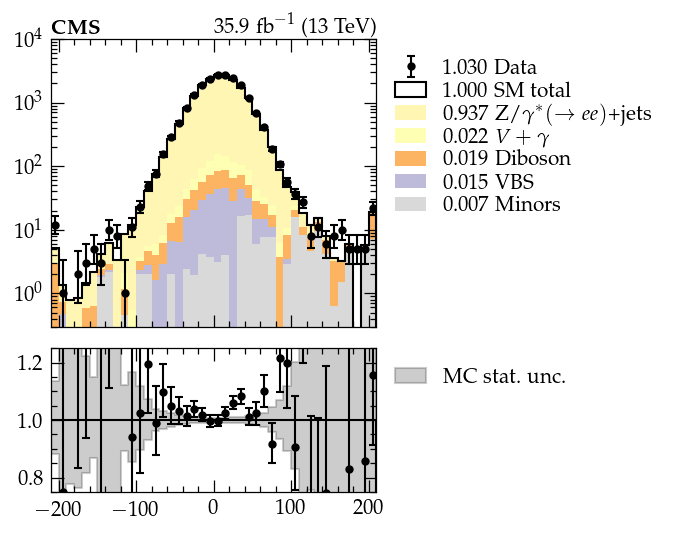

In [7]:
df_data_region = df_data.loc[("central", "ZCand_pt", "METnoX_ptParaZCandCent", "DoubleElectron", "SingleElectron"),:].groupby("binvar1").sum()
df_mc_region = df_mc.loc[("central", "ZCand_pt", "METnoX_ptParaZCandCent", "DoubleElectron"),:].groupby(["parent", "binvar1"]).sum()

fig, ax = plt.subplots(
    figsize=(3.5, 4), dpi=150,
    nrows=2, ncols=1,
    sharex=True, sharey=False,
    gridspec_kw={"height_ratios": (2, 1), "hspace": 0.1},
)
dftools.draw.cms_label(ax[0], "")

binning = np.arange(-210., 201., 10.)
df_data_region = dftools.transform.rebin(df_data_region, binning, label="binvar1")
df_mc_region = dftools.transform.rebin(df_mc_region, binning, label="binvar1")

df_mc_region = dftools.transform.merge(
    df_mc_region, {
        "Minor": ["DYJetsToTauHTauL", "WJetsToTauNu", "WJetsToENu", "DYJetsToTauLTauL", "SingleTop", "TTJets", "DYJetsToTauHTauH", "G1Jet"],
    }
)

dftools.draw.data_mc(
    ax, df_data_region, df_mc_region, "binvar1", binning,
    proc_kw={
        "labels": {"SMTotal": r'SM total', "MET": r'MET', "SingleMuon": r'Single Muon', "SingleElectron": r'Single Electron', "ZJetsToNuNu": r'$\mathrm{Z}(\rightarrow \nu\nu)$+jets', "WJetsToLNu": r'$\mathrm{W}(\rightarrow l\nu)$+jets', "WJetsToENu": r'$\mathrm{W}(\rightarrow e\nu)$+jets', "WJetsToMuNu": r'$\mathrm{W}(\rightarrow \mu\nu)$+jets', "WJetsToTauNu": r'$\mathrm{W}(\rightarrow \tau\nu)$+jets', "WJetsToTauLNu": r'$\mathrm{W}(\rightarrow \tau_{l}\nu)$+jets', "WJetsToTauHNu": r'$\mathrm{W}(\rightarrow \tau_{h}\nu)$+jets', "Diboson": r'Diboson', "DYJetsToLL": r'$\mathrm{Z}/\gamma^{*}(\rightarrow ll)$+jets', "DYJetsToEE": r'$\mathrm{Z}/\gamma^{*}(\rightarrow ee)$+jets', "DYJetsToMuMu": r'$\mathrm{Z}/\gamma^{*}(\rightarrow \mu\mu)$+jets', "DYJetsToTauTau": r'$\mathrm{Z}/\gamma^{*}(\rightarrow \tau\tau)$+jets', "DYJetsToTauLTauL": r'$\mathrm{Z}/\gamma^{*}(\rightarrow \tau_{l}\tau_{l})$+jet', "DYJetsToTauHTauL": r'$\mathrm{Z}/\gamma^{*}(\rightarrow \tau_{l}\tau_{h})$+jet', "DYJetsToTauHTauH": r'$\mathrm{Z}/\gamma^{*}(\rightarrow \tau_{h}\tau_{h})$+jet', "EWKV2Jets": r'VBS', "SingleTop": r'Single Top', "TTJets": r'$t\bar{t}$+jets', "QCD": r'Multijet', "G1Jet": r'$\gamma$+jets', "VGamma": r'$V+\gamma$', "Minor": r'Minors'},
        "colours": {"SMTotal": 'black', "MET": "black", "SingleMuon": "black", "SingleElectron": "black", "ZJetsToNuNu": '#80b1d3', "WJetsToLNu": '#b3de69', "WJetsToENu": '#b2df8a', "WJetsToMuNu": '#b3de69', "WJetsToTauNu": '#8dd3c7', "WJetsToTauLNu": '#8dd3c7', "WJetsToTauHNu": '#8dd3c7', "Diboson": '#fdb462', "DYJetsToLL": '#ffed6f', "DYJetsToEE": '#fff6b3', "DYJetsToMuMu": '#ffed6f', "DYJetsToTauTau": '#ffe41a', "DYJetsToTauLTauL": '#ffe41a', "DYJetsToTauHTauL": '#ffe41a', "DYJetsToTauHTauH": '#ffe41a', "EWKV2Jets": '#bebada', "SingleTop": '#fccde5', "TTJets": '#bc80bd', "QCD": '#fb8072', "G1Jet": '#ccebc5', "VGamma": '#ffffb3', "Minor": '#d9d9d9'},
    }
)
ax[0].set_ylim(0.3, 1e4)
ax[1].set_ylim(0.75, 1.25)
pass

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1976: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)


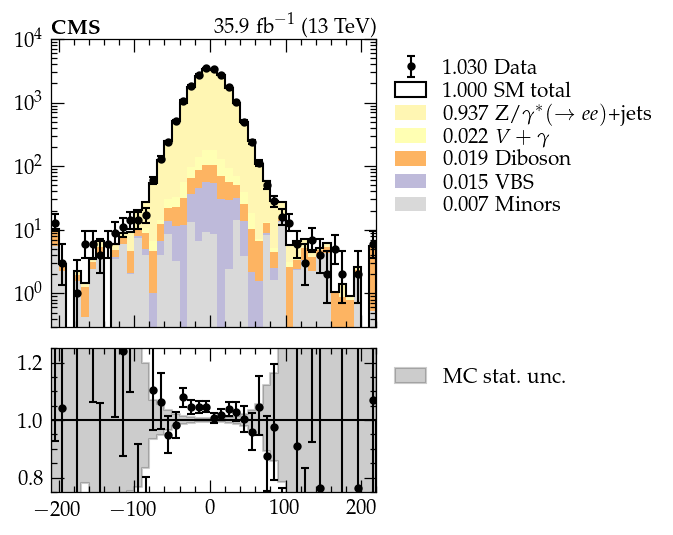

In [8]:
df_data_region = df_data.loc[("central", "ZCand_pt", "METnoX_ptPerpZCandCent", "DoubleElectron", "SingleElectron"),:].groupby("binvar1").sum()
df_mc_region = df_mc.loc[("central", "ZCand_pt", "METnoX_ptPerpZCandCent", "DoubleElectron"),:].groupby(["parent", "binvar1"]).sum()

fig, ax = plt.subplots(
    figsize=(3.5, 4), dpi=150,
    nrows=2, ncols=1,
    sharex=True, sharey=False,
    gridspec_kw={"height_ratios": (2, 1), "hspace": 0.1},
)
dftools.draw.cms_label(ax[0], "")

binning = np.arange(-210., 211., 10.)
df_data_region = dftools.transform.rebin(df_data_region, binning, label="binvar1")
df_mc_region = dftools.transform.rebin(df_mc_region, binning, label="binvar1")

df_mc_region = dftools.transform.merge(
    df_mc_region, {
        "Minor": ["DYJetsToTauHTauL", "WJetsToTauNu", "WJetsToENu", "DYJetsToTauLTauL", "SingleTop", "TTJets", "DYJetsToTauHTauH", "G1Jet"],
    }
)

dftools.draw.data_mc(
    ax, df_data_region, df_mc_region, "binvar1", binning,
    proc_kw={
        "labels": {"SMTotal": r'SM total', "MET": r'MET', "SingleMuon": r'Single Muon', "SingleElectron": r'Single Electron', "ZJetsToNuNu": r'$\mathrm{Z}(\rightarrow \nu\nu)$+jets', "WJetsToLNu": r'$\mathrm{W}(\rightarrow l\nu)$+jets', "WJetsToENu": r'$\mathrm{W}(\rightarrow e\nu)$+jets', "WJetsToMuNu": r'$\mathrm{W}(\rightarrow \mu\nu)$+jets', "WJetsToTauNu": r'$\mathrm{W}(\rightarrow \tau\nu)$+jets', "WJetsToTauLNu": r'$\mathrm{W}(\rightarrow \tau_{l}\nu)$+jets', "WJetsToTauHNu": r'$\mathrm{W}(\rightarrow \tau_{h}\nu)$+jets', "Diboson": r'Diboson', "DYJetsToLL": r'$\mathrm{Z}/\gamma^{*}(\rightarrow ll)$+jets', "DYJetsToEE": r'$\mathrm{Z}/\gamma^{*}(\rightarrow ee)$+jets', "DYJetsToMuMu": r'$\mathrm{Z}/\gamma^{*}(\rightarrow \mu\mu)$+jets', "DYJetsToTauTau": r'$\mathrm{Z}/\gamma^{*}(\rightarrow \tau\tau)$+jets', "DYJetsToTauLTauL": r'$\mathrm{Z}/\gamma^{*}(\rightarrow \tau_{l}\tau_{l})$+jet', "DYJetsToTauHTauL": r'$\mathrm{Z}/\gamma^{*}(\rightarrow \tau_{l}\tau_{h})$+jet', "DYJetsToTauHTauH": r'$\mathrm{Z}/\gamma^{*}(\rightarrow \tau_{h}\tau_{h})$+jet', "EWKV2Jets": r'VBS', "SingleTop": r'Single Top', "TTJets": r'$t\bar{t}$+jets', "QCD": r'Multijet', "G1Jet": r'$\gamma$+jets', "VGamma": r'$V+\gamma$', "Minor": r'Minors'},
        "colours": {"SMTotal": 'black', "MET": "black", "SingleMuon": "black", "SingleElectron": "black", "ZJetsToNuNu": '#80b1d3', "WJetsToLNu": '#b3de69', "WJetsToENu": '#b2df8a', "WJetsToMuNu": '#b3de69', "WJetsToTauNu": '#8dd3c7', "WJetsToTauLNu": '#8dd3c7', "WJetsToTauHNu": '#8dd3c7', "Diboson": '#fdb462', "DYJetsToLL": '#ffed6f', "DYJetsToEE": '#fff6b3', "DYJetsToMuMu": '#ffed6f', "DYJetsToTauTau": '#ffe41a', "DYJetsToTauLTauL": '#ffe41a', "DYJetsToTauHTauL": '#ffe41a', "DYJetsToTauHTauH": '#ffe41a', "EWKV2Jets": '#bebada', "SingleTop": '#fccde5', "TTJets": '#bc80bd', "QCD": '#fb8072', "G1Jet": '#ccebc5', "VGamma": '#ffffb3', "Minor": '#d9d9d9'},
    }
)
ax[0].set_ylim(0.3, 1e4)
ax[1].set_ylim(0.75, 1.25)
pass

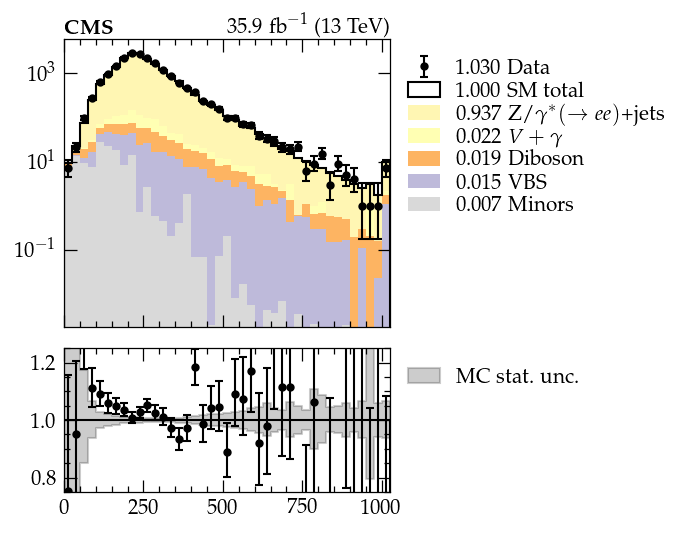

In [9]:
df_data_region = df_data.loc[("central", "ZCand_pt", "METnoX_ptPerpZCandCent", "DoubleElectron", "SingleElectron"),:].groupby(["binvar0"]).sum()
df_mc_region = df_mc.loc[("central", "ZCand_pt", "METnoX_ptPerpZCandCent", "DoubleElectron"),:].groupby(["parent", "binvar0"]).sum()

fig, ax = plt.subplots(
    figsize=(3.5, 4), dpi=150,
    nrows=2, ncols=1,
    sharex=True, sharey=False,
    gridspec_kw={"height_ratios": (2, 1), "hspace": 0.1},
)
dftools.draw.cms_label(ax[0], "")

binning = np.arange(0., 1001., 25.)
df_data_region = dftools.transform.rebin(df_data_region, binning, label="binvar0")
df_mc_region = dftools.transform.rebin(df_mc_region, binning, label="binvar0")

df_mc_region = dftools.transform.merge(
    df_mc_region, {
        "Minor": ["DYJetsToTauHTauL", "WJetsToTauNu", "WJetsToENu", "DYJetsToTauLTauL", "SingleTop", "TTJets", "DYJetsToTauHTauH", "G1Jet"],
    }
)

dftools.draw.data_mc(
    ax, df_data_region, df_mc_region, "binvar0", binning,
    proc_kw={
        "labels": {"SMTotal": r'SM total', "MET": r'MET', "SingleMuon": r'Single Muon', "SingleElectron": r'Single Electron', "ZJetsToNuNu": r'$\mathrm{Z}(\rightarrow \nu\nu)$+jets', "WJetsToLNu": r'$\mathrm{W}(\rightarrow l\nu)$+jets', "WJetsToENu": r'$\mathrm{W}(\rightarrow e\nu)$+jets', "WJetsToMuNu": r'$\mathrm{W}(\rightarrow \mu\nu)$+jets', "WJetsToTauNu": r'$\mathrm{W}(\rightarrow \tau\nu)$+jets', "WJetsToTauLNu": r'$\mathrm{W}(\rightarrow \tau_{l}\nu)$+jets', "WJetsToTauHNu": r'$\mathrm{W}(\rightarrow \tau_{h}\nu)$+jets', "Diboson": r'Diboson', "DYJetsToLL": r'$\mathrm{Z}/\gamma^{*}(\rightarrow ll)$+jets', "DYJetsToEE": r'$\mathrm{Z}/\gamma^{*}(\rightarrow ee)$+jets', "DYJetsToMuMu": r'$\mathrm{Z}/\gamma^{*}(\rightarrow \mu\mu)$+jets', "DYJetsToTauTau": r'$\mathrm{Z}/\gamma^{*}(\rightarrow \tau\tau)$+jets', "DYJetsToTauLTauL": r'$\mathrm{Z}/\gamma^{*}(\rightarrow \tau_{l}\tau_{l})$+jet', "DYJetsToTauHTauL": r'$\mathrm{Z}/\gamma^{*}(\rightarrow \tau_{l}\tau_{h})$+jet', "DYJetsToTauHTauH": r'$\mathrm{Z}/\gamma^{*}(\rightarrow \tau_{h}\tau_{h})$+jet', "EWKV2Jets": r'VBS', "SingleTop": r'Single Top', "TTJets": r'$t\bar{t}$+jets', "QCD": r'Multijet', "G1Jet": r'$\gamma$+jets', "VGamma": r'$V+\gamma$', "Minor": r'Minors'},
        "colours": {"SMTotal": 'black', "MET": "black", "SingleMuon": "black", "SingleElectron": "black", "ZJetsToNuNu": '#80b1d3', "WJetsToLNu": '#b3de69', "WJetsToENu": '#b2df8a', "WJetsToMuNu": '#b3de69', "WJetsToTauNu": '#8dd3c7', "WJetsToTauLNu": '#8dd3c7', "WJetsToTauHNu": '#8dd3c7', "Diboson": '#fdb462', "DYJetsToLL": '#ffed6f', "DYJetsToEE": '#fff6b3', "DYJetsToMuMu": '#ffed6f', "DYJetsToTauTau": '#ffe41a', "DYJetsToTauLTauL": '#ffe41a', "DYJetsToTauHTauL": '#ffe41a', "DYJetsToTauHTauH": '#ffe41a', "EWKV2Jets": '#bebada', "SingleTop": '#fccde5', "TTJets": '#bc80bd', "QCD": '#fb8072', "G1Jet": '#ccebc5', "VGamma": '#ffffb3', "Minor": '#d9d9d9'},
    }
)
ax[1].set_ylim(0.75, 1.25)
pass

In [10]:
df_data_region = df_data.loc[("central", "ZCand_pt", "METnoX_ptPerpZCandCent", "DoubleElectron", "SingleElectron"),:].groupby(["binvar0"]).sum()
df_data_total = df_data_region["sum_w"].sum()

bin_low = df_data_region.index.get_level_values("binvar0")
bin_edge = np.array(list(bin_low) + [2*bin_low[-1]-bin_low[1]])
bin_cent = (bin_edge[:-1] + bin_edge[1:])/2.

nbins = 20
xvals = []
for idx in range(1, nbins):
    xval = dftools.numpy.intersection(
        bin_cent, df_data_region["sum_w"].cumsum().values,
        bin_cent, np.ones_like(bin_cent)*df_data_total*idx/float(nbins),
    )[0]
    xvals.append(xval[0])
print(np.array(xvals))

[121.21896552 147.515625   165.95916667 179.45813953 190.45528017
 200.0099278  208.78505843 217.1795302  225.70412458 234.1712204
 243.51114341 253.62043011 265.10106383 277.73342541 292.26715686
 310.36938776 335.22263682 371.86693548 437.26875   ]


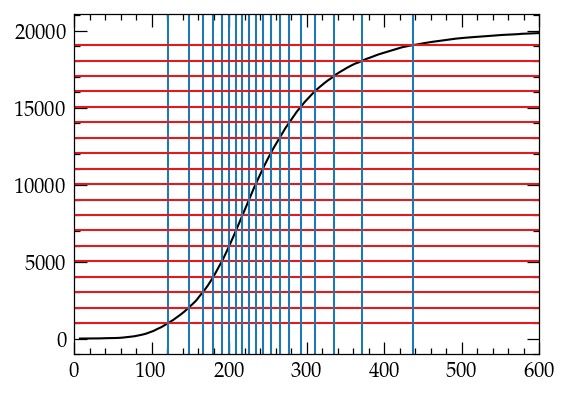

In [11]:
df_data_region = df_data.loc[("central", "ZCand_pt", "METnoX_ptPerpZCandCent", "DoubleElectron", "SingleElectron"),:].groupby(["binvar0"]).sum()

df_data_total = df_data_region["sum_w"].sum()
df_data_total / 20.

fig, ax = plt.subplots(figsize=(4, 3), dpi=150)

bin_low = df_data_region.index.get_level_values("binvar0")
bin_edge = np.array(list(bin_low) + [2*bin_low[-1]-bin_low[1]])
bin_cent = (bin_edge[:-1] + bin_edge[1:])/2.

mask = (df_data_region.index.get_level_values("binvar0")>100.)
ax.plot(
    bin_cent,
    df_data_region["sum_w"].cumsum(),
    color='black',
)
ax.set_xlim(0., 600.)

for idx in range(1, nbins):
    ax.axhline(df_data_total*idx/float(nbins), color="#e31a1c")
    ax.axvline(xvals[idx-1], color="#1f78b4")

In [12]:
zpt_bin_edges = np.array([0.] + list(xvals) + [np.inf])
zpt_bin_edges

array([  0.        , 121.21896552, 147.515625  , 165.95916667,
       179.45813953, 190.45528017, 200.0099278 , 208.78505843,
       217.1795302 , 225.70412458, 234.1712204 , 243.51114341,
       253.62043011, 265.10106383, 277.73342541, 292.26715686,
       310.36938776, 335.22263682, 371.86693548, 437.26875   ,
                inf])

In [13]:
zpt_bin_edges_round = np.round(zpt_bin_edges/5.)*5.
zpt_bin_edges_round[:-1]

array([  0., 120., 150., 165., 180., 190., 200., 210., 215., 225., 235.,
       245., 255., 265., 280., 290., 310., 335., 370., 435.])

In [14]:
import scipy
import iminuit

def voigt(x, x0, gamma, sigma):
    z = ((x-x0) + 1j*gamma) / (sigma*np.sqrt(2))
    return np.real(scipy.special.wofz(z))/(sigma*np.sqrt(2*np.pi))
    
def sig_pdf(bins, observable, sig_norm, shape_params):
    x0, gamma, sigmav = shape_params[:]
    sigma = np.sqrt(np.maximum(0., (
        (sigmav - (0.5346/np.sqrt(2*np.log(2)))*gamma)**2
        - (0.2166/(2*np.log(2)))*gamma**2
    )))
    shape = voigt(observable, x0, gamma, sigma) * (bins[1]-bins[0])
    return sig_norm * shape / shape.sum()

def bkg_pdf(bkg, bkg_norm):
    return bkg_norm * bkg / bkg.sum()

def pred_pdf(bins, observable, sig_norm, sig_scale, shape_params, bkg, bkg_norm, bkg_scale):
    return sig_pdf(bins, observable, sig_norm*sig_scale, shape_params) + bkg_pdf(bkg, bkg_norm*bkg_scale)

def nll_sigonly(bins, observable, sig, sig_neff, params, sat=False):
    sig_norm = sig.sum()
    sig_scale = params[0]
    shape_params = params[1:4]
    
    pred = sig_pdf(bins, observable, sig_norm*sig_scale, shape_params)
    
    scale = np.ones_like(sig)
    mask = (pred>1e-10) & (sig_neff>1e-10)
    scale[mask] = (pred/sig_neff)[mask]
    sig[~mask] = 0.
    sig_neff[~mask] = 0.
    
    gam_pdf = np.sum(scipy.stats.gamma.logpdf(sig, sig_neff+1, scale=scale))
    return -2*gam_pdf

def nll(bins, observable, data, sig, bkg, bkg_neff, params, sat=False):
    sig_norm = sig.sum()
    bkg_norm = bkg.sum()
    
    sig_scale, bkg_scale = params[:2]
    shape_params = params[2:5]
    mcstat_params = np.array(params[5:])
    
    # only constrain background mc stat when background exists in that bin
    pred = pred_pdf(bins, observable, sig_norm, sig_scale, shape_params, mcstat_params, bkg_norm, bkg_scale)
    if sat:
        pred = data
    pois_pdf = np.sum(scipy.stats.poisson.logpmf(data, pred))
    
    scale = np.ones_like(bkg)
    mask = (bkg>1e-10) & (bkg_neff>1e-10)
    scale[mask] = (bkg/bkg_neff)[mask]
    bkg[~mask] = 0.
    bkg_neff[~mask] = 0.
    
    nuis_pdf = np.sum(scipy.stats.gamma.logpdf(mcstat_params, bkg_neff+1, scale=scale))
    return -2*(pois_pdf + nuis_pdf)

def gen_data(bins, observable, sig, bkg, bkg_neff, params, seed=123456):
    np.random.seed(seed)
    sig_norm = sig.sum()
    bkg_norm = bkg.sum()
    
    sig_scale, bkg_scale = params[:2]
    shape_params = params[2:5]
    mcstat_params = np.array(params[5:])
    
    pred = pred_pdf(bins, observable, sig_norm, sig_scale, shape_params, mcstat_params, bkg_norm, bkg_scale)
    return scipy.stats.poisson.rvs(pred)

In [15]:
import numdifftools

class LogLHData(object):
    def __init__(self, fnll, fsig, fbkg, fgen):
        self._fnll = fnll
        self._data_set = False
        
        self._fsig = fsig
        self._fbkg = fbkg
        self._fgen = fgen
        
    def set_data(self, bins, dfdata, dfmc, fcn="voigt"):
        self._dfdata = dfdata
        self._dfmc = dfmc
        
        self._data_set = True
        self._bins = bins
        self._obs = (bins[1]+bins[0])/2.
        self._data = dfdata["sum_w"].values
        self._bkg = np.maximum(0., dfmc["sum_w"].values)
        self._bkg_neff = dfmc.eval("sum_w**2/sum_ww").values
        self._sig = np.maximum(0., self._data - self._bkg)
        
        if fcn == "voigt":
            self._params = ["rsig", "rbkg", "x0", "gamma", "sigmav"]
            self._params.extend([f'bneff{idx}' for idx in range(bins[0].shape[0])])
            
            x0_prefit = (self._data*self._obs).sum()/self._data.sum()
            self._init_params = [1., 1., x0_prefit, 1., 20.]
            self._init_params.extend(self._bkg)
            self._init_params = np.array(self._init_params)
        
            self._lim_params = [(0.5, 2), (0.5, 2), (-100, 100), (0, 100), (0, 100)]
            self._lim_params.extend([(0, None) for idx in range(bins[0].shape[0])])
        
            self._fix_params = [False, True, False, False, False]
            self._fix_params.extend([False for idx in range(bins[0].shape[0])])
        elif fcn == "gauss":
            self._params = ["rsig", "rbkg", "x0", "gamma", "sigmav"]
            self._params.extend([f'bneff{idx}' for idx in range(bins[0].shape[0])])
            
            x0_prefit = (self._data*self._obs).sum()/self._data.sum()
            self._init_params = [1., 1., x0_prefit, 0., 20.]
            self._init_params.extend(self._bkg)
            self._init_params = np.array(self._init_params)
        
            self._lim_params = [(0.5, 2), (0.5, 2), (-100, 100), (0, 100), (0, 100)]
            self._lim_params.extend([(0, None) for idx in range(bins[0].shape[0])])
        
            self._fix_params = [False, True, False, True, False]
            self._fix_params.extend([False for idx in range(bins[0].shape[0])])
        
    def __call__(self, params, saturated=False):
        self._params_vals = params
        return self.evaluate(saturated=saturated)
        
    def evaluate(self, saturated=False):
        if not self._data_set:
            raise RuntimeError("Data is not set for LogLH")
        return self._fnll(self._bins, self._obs, self._data, self._sig, self._bkg, self._bkg_neff, self._params_vals, sat=saturated)
    
    def get_minuit_args(self):
        return (self._init_params,)
        
    def get_minuit_kwargs(self):
        return {
            "name": self._params,
            "fix": self._fix_params,
            "limit": self._lim_params,
        }
    
    def create_minuit(self, **kwargs):
        _kwargs = copy.deepcopy(self.get_minuit_kwargs())
        _kwargs.update({"errordef": 1, "pedantic": False})
        _kwargs.update(kwargs)
        return iminuit.Minuit.from_array_func(
            self, *self.get_minuit_args(), **_kwargs,
        )
    
    def sig_pdf(self, params, rebin=None):
        sig_norm = self._sig.sum()*params[0]
        sig = self._fsig(self._bins, self._obs, sig_norm, params[2:5])
        
        if rebin is not None:
            sig_rebin = self._fsig(rebin, (rebin[:-1]+rebin[1:])/2., sig_norm, params[2:5])
            return sig_rebin*float(rebin.shape[0])#/float(self._bins[0].shape[0])
        return sig
    
    def sig_pdf_ci(self, params, covariance, rebin=None):
        jac = numdifftools.Jacobian(lambda x: self.sig_pdf(x, rebin=rebin))(params)
        return scipy.stats.chi2.ppf(0.68, df=1)*np.sqrt(np.matmul(jac, np.matmul(covariance, jac.T)).diagonal())
    
    def bkg_pdf(self, params):
        bkg_norm = self._bkg.sum()*params[1]
        return self._fbkg(params[5:], bkg_norm)
    
    def bkg_pdf_ci(self, params, covariance):
        jac = numdifftools.Jacobian(self.bkg_pdf)(params)
        return scipy.stats.chi2.ppf(0.68, df=1)*np.sqrt(np.matmul(jac, np.matmul(covariance, jac.T)).diagonal())
    
    def pred_pdf(self, params):
        return self.sig_pdf(params) + self.bkg_pdf(params)
    
    def pred_pdf_ci(self, params, covariance):
        jac = numdifftools.Jacobian(self.pred_pdf)(params)
        return scipy.stats.chi2.ppf(0.68, df=1)*np.sqrt(np.matmul(jac, np.matmul(covariance, jac.T)).diagonal())
    
    def gen_toy(self, params, seed=123456):
        return self._fgen(self._bins, self._obs, self._sig, self._bkg, self._bkg_neff, params, seed=seed)

In [16]:
class LogLHMC(object):
    def __init__(self, fnll, fsig, fgen):
        self._fnll = fnll
        self._data_set = False
        
        self._fsig = fsig
        self._fgen = fgen
        
    def set_data(self, bins, dfmc, variation="", fcn="voigt"):
        if variation != "":
            variation = "_"+variation
            
        self._dfmc = dfmc
        
        self._data_set = True
        self._bins = bins
        self._obs = (bins[1]+bins[0])/2.
        self._sig = np.maximum(0., dfmc["sum_w{}".format(variation)].values)
        self._sig_neff = dfmc.eval("sum_w{0}**2/sum_ww{0}".format(variation)).values
        
        if fcn == "voigt":
            x0_prefit = (self._sig*self._obs).sum()/self._sig.sum()
            self._params = ["rsig", "x0", "gamma", "sigmav"]
            self._init_params = [1., x0_prefit, 1., 20.]
            self._lim_params = [(0.5, 2), (-100, 100), (0, 100), (0, 100)]
            self._fix_params = [False, False, False, False]
        elif fcn == "gauss":
            x0_prefit = (self._sig*self._obs).sum()/self._sig.sum()
            self._params = ["rsig", "x0", "gamma", "sigmav"]
            self._init_params = [1., x0_prefit, 0., 20.]
            self._lim_params = [(0.5, 2), (-100, 100), (0, 100), (0, 100)]
            self._fix_params = [False, False, True, False]
         
    def __call__(self, params, saturated=False):
        self._params_vals = params
        return self.evaluate(saturated=saturated)
        
    def evaluate(self, saturated=False):
        if not self._data_set:
            raise RuntimeError("Data is not set for LogLH")
        return self._fnll(self._bins, self._obs, self._sig, self._sig_neff, self._params_vals, sat=saturated)
    
    def get_minuit_args(self):
        return (self._init_params,)
        
    def get_minuit_kwargs(self):
        return {
            "name": self._params,
            "fix": self._fix_params,
            "limit": self._lim_params,
        }
    
    def create_minuit(self, **kwargs):
        _kwargs = copy.deepcopy(self.get_minuit_kwargs())
        _kwargs.update({"errordef": 1, "pedantic": False})
        _kwargs.update(kwargs)
        return iminuit.Minuit.from_array_func(
            self, *self.get_minuit_args(), **_kwargs,
        )
    
    def sig_pdf(self, params, rebin=None):
        sig_norm = self._sig.sum()*params[0]
        sig = self._fsig(self._bins, self._obs, sig_norm, params[1:])
        
        if rebin is not None:
            sig_rebin = self._fsig(rebin, (rebin[:-1]+rebin[1:])/2., sig_norm, params[1:])
            return sig_rebin*float(rebin.shape[0])#/float(self._bins[0].shape[0])
        return sig
    
    def sig_pdf_ci(self, params, covariance, rebin=None):
        jac = numdifftools.Jacobian(lambda x: self.sig_pdf(x, rebin=rebin))(params)
        return scipy.stats.chi2.ppf(0.68, df=1)*np.sqrt(np.matmul(jac, np.matmul(covariance, jac.T)).diagonal())
    
    def bkg_pdf(self, params):
        raise NotImplementedError
    
    def bkg_pdf_ci(self, params, covariance):
        raise NotImplementedError
    
    def pred_pdf(self, params):
        return self.sig_pdf(params)
    
    def pred_pdf_ci(self, params, covariance):
        jac = numdifftools.Jacobian(self.pred_pdf)(params)
        return scipy.stats.chi2.ppf(0.68, df=1)*np.sqrt(np.matmul(jac, np.matmul(covariance, jac.T)).diagonal())
    
    def gen_toy(self, params, seed=123456):
        return self._fgen(self._bins, self._obs, self._sig, self._sig_neff, params, seed=seed)

In [17]:
def draw_data_fit_results(ax, model, minimizer, legend_kw={}):
    bin_low, bin_high = model._bins
    bins = np.array(list(bin_low) + [bin_high[-1]])
    obs = model._obs
    data = model._data

    fine_bins = np.linspace(bin_low.min(), bin_high.max(), bin_low.shape[0]*10+1)
    signal = model.sig_pdf(minimizer.np_values(), rebin=fine_bins)
    background = model.bkg_pdf(minimizer.np_values())
    prediction = model.pred_pdf(minimizer.np_values())

    ax[0].set_xlim(bin_low.min(), bin_high.max())
    ax[0].set_yscale('log')
    #ax[0].set_ylabel('Events')
    #dftools.draw.cms_label(ax[0], '')
    
    # Data points
    errlow, errhigh = dftools.stats.poisson_interval(data)
    ax[0].errorbar(
        obs, data, yerr=((data-errlow), (errhigh-data)),
        fmt='o', color='black', lw=1, label='Data',
    )
    
    # Fit prediction
    ax[0].hist(
        obs, bins=bins, weights=prediction,
        histtype='step', color='#1f78b4', label='Fit',
    )
    sigma = model.pred_pdf_ci(minimizer.np_values(), minimizer.np_matrix(skip_fixed=False))
    ax[0].fill_between(
        bins, list(prediction+sigma)+[(prediction+sigma)[-1]],
        list(prediction-sigma)+[(prediction-sigma)[-1]],
        step='post', color='#1f78b4', alpha=0.3,
    )
    
    # Signal
    ax[0].plot(
        (fine_bins[1:]+fine_bins[:-1])/2, signal/40.,
        '-', color='#ff7f00', lw=1, label='Sig.',
    )
    
    # Background
    ax[0].hist(
        obs, bins=bins, weights=background,
        color='#e31a1c', label='Bkg.',
        alpha=0.5,
    )
    
    # Background prefit
    bkg_prefit = model._bkg
    ax[0].hist(
        obs, bins=bins, weights=bkg_prefit,
        color='#e31a1c', histtype='step',
        ls='--', label='Bkg. prefit',
    )
    
    #handles, labels = ax[0].get_legend_handles_labels()
    #kwargs = {"loc": 2, "labelspacing": 0.2}
    #kwargs.update(legend_kw)
    #ax[0].legend(
    #    handles[::-1], labels[::-1],
    #    **kwargs,
    #)
    
    # lower panel
    #ax[1].set_ylabel("Data/Pred. - 1")
    
    # Ratio data
    ax[1].errorbar(
        obs, (data/prediction-1), yerr=(((data-errlow)/prediction), ((errhigh-data)/prediction)),
        fmt='o', color='black', lw=1,
    )
    
    # Ratio pred
    ax[1].hist(
        obs, bins=bins, weights=np.zeros_like(prediction),
        histtype='step', color='#1f78b4',
    )
    up = sigma/prediction
    do = -sigma/prediction
    ax[1].fill_between(
        bins, list(up)+[up[-1]], list(do)+[do[-1]],
        step='post', color='#1f78b4', alpha=0.3,
    )

In [18]:
def draw_mc_fit_results(ax, model, minimizer, legend_kw={}):
    bin_low, bin_high = model._bins
    bins = np.array(list(bin_low) + [bin_high[-1]])
    obs = model._obs
    sig = model._sig
    sig_neff = model._sig_neff

    fine_bins = np.linspace(bin_low.min(), bin_high.max(), bin_low.shape[0]*10+1)
    signal = model.sig_pdf(minimizer.np_values(), rebin=fine_bins)
    prediction = model.pred_pdf(minimizer.np_values())

    ax[0].set_xlim(bin_low.min(), bin_high.max())
    ax[0].set_yscale('log')
    #ax[0].set_ylabel('Events')
    #dftools.draw.cms_label(ax[0], '')
    
    # Data points
    errlow, errhigh = dftools.stats.poisson_interval(sig_neff, scale=sig/sig_neff)
    ax[0].errorbar(
        obs, sig, yerr=((sig-errlow), (errhigh-sig)),
        fmt='o', color='black', lw=1, label='MC',
    )
    
    # Fit prediction
    ax[0].hist(
        obs, bins=bins, weights=prediction,
        histtype='step', color='#1f78b4', label='Fit',
    )
    sigma = model.pred_pdf_ci(minimizer.np_values(), minimizer.np_matrix(skip_fixed=False))
    ax[0].fill_between(
        bins, list(prediction+sigma)+[(prediction+sigma)[-1]],
        list(prediction-sigma)+[(prediction-sigma)[-1]],
        step='post', color='#1f78b4', alpha=0.3,
    )
    
    # Signal
    ax[0].plot(
        (fine_bins[1:]+fine_bins[:-1])/2, signal/40.,
        '-', color='#ff7f00', lw=1, label='Sig.',
    )
    
    #handles, labels = ax[0].get_legend_handles_labels()
    #kwargs = {"loc": 2, "labelspacing": 0.2}
    #kwargs.update(legend_kw)
    #ax[0].legend(
    #    handles[::-1], labels[::-1],
    #    **kwargs,
    #)
    
    # lower panel
    #ax[1].set_ylabel("MC/Pred. - 1")
    
    # Ratio data
    ax[1].errorbar(
        obs, (sig/prediction-1), yerr=(((sig-errlow)/prediction), ((errhigh-sig)/prediction)),
        fmt='o', color='black', lw=1,
    )
    
    # Ratio pred
    ax[1].hist(
        obs, bins=bins, weights=np.zeros_like(prediction),
        histtype='step', color='#1f78b4',
    )
    up = sigma/prediction
    do = -sigma/prediction
    ax[1].fill_between(
        bins, list(up)+[up[-1]], list(do)+[do[-1]],
        step='post', color='#1f78b4', alpha=0.3,
    )

In [19]:
def perform_data_fit(model, binning, df_data, df_mc, idx=0, fcn="voigt"):
    _df_data_region = dftools.transform.rebin(
        dftools.transform.rebin(
            df_data, zpt_bin_edges_round, label="binvar0",
        ), binning, label="binvar1",
    ).loc[(zpt_bin_edges_round[idx],),:].groupby("binvar1").sum()
    _df_mc_region = dftools.transform.rebin(
        dftools.transform.rebin(
            dftools.transform.merge(
                df_mc, {
                    "Background": ["DYJetsToTauHTauH", "DYJetsToTauHTauL", "DYJetsToTauLTauL", "Diboson", "EWKV2Jets", "G1Jet", "SingleTop", "TTJets", "VGamma", "WJetsToENu", "WJetsToTauNu"],
                }
            ), zpt_bin_edges_round, label="binvar0",
        ), binning, label="binvar1",
    ).loc[("Background",zpt_bin_edges_round[idx],),:].groupby("binvar1").sum()
    
    _df_data_region = _df_data_region.iloc[1:-1]
    _df_mc_region = _df_mc_region.iloc[1:-1].groupby("binvar1").sum()
    def _rebin(_dfdata, _dfmc, _bins):
        _dfdata_rebin = dftools.transform.rebin(_dfdata, _bins, label="binvar1")
        _dfmc_rebin = dftools.transform.rebin(_dfmc, _bins, label="binvar1")
        return _dfdata_rebin, _dfmc_rebin
        
    new_bins = binning[1:]
    while (_df_mc_region["sum_w"]<0.).any():
        imin = _df_mc_region["sum_w"].reset_index(drop=True).idxmin()
        imin = min(len(new_bins)-2, max(1, imin))
        new_bins = np.delete(new_bins, imin)
        _df_data_region, _df_mc_region = _rebin(
            _df_data_region, _df_mc_region, new_bins,
        )
    _df_data_region, _df_mc_region = _rebin(
        _df_data_region, _df_mc_region, new_bins,
    )
    
    try:
        model.set_data(
            (new_bins[:-1], new_bins[1:]),
            _df_data_region.iloc[:-1], _df_mc_region.iloc[:-1],
            fcn="voigt",
        )
        minimizer = model.create_minuit()
        minimizer.migrad()
        minimizer.minos()
    except RuntimeError:
        model.set_data(
            (new_bins[:-1], new_bins[1:]),
            _df_data_region.iloc[:-1], _df_mc_region.iloc[:-1],
            fcn="gauss",
        )
        minimizer = model.create_minuit()
        minimizer.migrad()
        minimizer.minos()
    return model, minimizer

In [20]:
def perform_mc_fit(model, binning, df_mc, variation="", idx=0, fcn="voigt"):
    _df_mc_region = dftools.transform.rebin(
        dftools.transform.rebin(
            df_mc, zpt_bin_edges_round, label="binvar0",
        ), binning, label="binvar1",
    ).loc[("DYJetsToEE",zpt_bin_edges_round[idx],),:].groupby("binvar1").sum()
    _df_mc_region = _df_mc_region.iloc[1:-1].groupby("binvar1").sum()
    
    def _rebin(_dfmc, _bins):
        return dftools.transform.rebin(_dfmc, _bins, label="binvar1")
    
    new_bins = binning[1:]
    if variation!="":
        vari = "_"+variation
    else:
        vari = variation
    while (_df_mc_region["sum_w{}".format(vari)]<0.).any():
        try:
            imin = _df_mc_region["sum_w{}".format(vari)].reset_index(drop=True).idxmin()
            imin = min(len(new_bins)-2, max(1, imin))
            new_bins = np.delete(new_bins, imin)
            _df_mc_region = _rebin(_df_mc_region, new_bins)
        except IndexError:
            return None, None
    _df_mc_region = _rebin(_df_mc_region, new_bins)
    
    try:
        model.set_data(
            (new_bins[:-1], new_bins[1:]),
            _df_mc_region.iloc[:-1],
            fcn=fcn, variation=variation,
        )
        _minimizer = model.create_minuit()
        _minimizer.migrad()
        _minimizer.minos()
    except RuntimeError:
        model.set_data(
            (new_bins[:-1], new_bins[1:]),
            _df_mc_region.iloc[:-1],
            fcn="gauss", variation=variation,
        )
        _minimizer = model.create_minuit()
        _minimizer.migrad()
        _minimizer.minos()
    return model, _minimizer

In [21]:
def perform_mc_fit_multipscale(model, binning, df_mc, variation="", idx=0, fcn="voigt"):
    vari = "_"+variation if variation!="" else variation
    vari_noupdown = vari[:-4] if vari.endswith("Down") else vari[:-2] if vari.endswith("Up") else vari
        
    _df_mc_region = dftools.transform.rebin(
        dftools.transform.rebin(
            df_mc_region, zpt_bin_edges_round, label="binvar0",
        ), binning, label="binvar1",
    ).loc[(pd.IndexSlice[:], "DYJetsToEE", zpt_bin_edges_round[idx],), :].groupby(["table", "binvar1"]).sum()
    
    _df_mc_region = _df_mc_region.loc[
        (_df_mc_region.index.get_level_values("binvar1")!=_df_mc_region.index.get_level_values("binvar1").min())
        & (_df_mc_region.index.get_level_values("binvar1")!=_df_mc_region.index.get_level_values("binvar1").max())
    ].groupby(["table", "binvar1"]).sum()
    
    import scipy.special
    x = np.sqrt(2)*scipy.special.erfinv(2*np.arange(0.1, 0.91, 0.1)-1)
    
    def interpolate_errors(x, y, deg=3):
        results = np.polyval(
            np.polyfit(x, y, deg=deg),
            [-1., 1.],
        )
        return pd.Series({"down":results[0], "up":results[1]})
    
    _df_mc_interp = pd.pivot_table(
        _df_mc_region, values=["sum_w"], index=["binvar1"], columns=["table"],
    ).apply(lambda r: interpolate_errors(x, r), axis=1)
    _df_mc_interp.columns = ["sum_w{}Down".format(vari_noupdown), "sum_w{}Up".format(vari_noupdown)]
    
    _df_mc_region["neff"] = _df_mc_region.eval("sum_w**2/sum_ww").fillna(0.)
    _df_mc_interp_ww = pd.pivot_table(
        _df_mc_region, values=["neff"], index=["binvar1"], columns=["table"],
    ).apply(lambda r: interpolate_errors(x, r, deg=1), axis=1)
    _df_mc_interp_ww.columns = ["sum_w{}Down".format(vari_noupdown), "sum_w{}Up".format(vari_noupdown)]
    _df_mc_interp_ww = (_df_mc_interp**2/_df_mc_interp_ww).fillna(0.)
    _df_mc_interp_ww.columns = ["sum_ww{}Down".format(vari_noupdown), "sum_ww{}Up".format(vari_noupdown)]
    
    _df_mc_interp = pd.concat([_df_mc_interp, _df_mc_interp_ww], axis=1)

    def _rebin(_dfmc, _bins):
        return dftools.transform.rebin(_dfmc, _bins, label="binvar1")
    
    new_bins = binning[1:]
    while (_df_mc_interp["sum_w{}".format(vari)]<0.).any():
        try:
            imin = _df_mc_interp["sum_w{}".format(vari)].reset_index(drop=True).idxmin()
            imin = min(len(new_bins)-2, max(1, imin))
            new_bins = np.delete(new_bins, imin)
            _df_mc_interp = _rebin(_df_mc_interp, new_bins)
        except IndexError:
            return None, None
    _df_mc_interp = _rebin(_df_mc_interp, new_bins)
    
    try:
        model.set_data(
            (new_bins[:-1], new_bins[1:]),
            _df_mc_interp.iloc[:-1],
            fcn=fcn, variation=variation,
        )
        _minimizer = model.create_minuit()
        _minimizer.migrad()
        _minimizer.minos()
    except RuntimeError:
        model.set_data(
            (new_bins[:-1], new_bins[1:]),
            _df_mc_interp.iloc[:-1],
            fcn="gauss", variation=variation,
        )
        _minimizer = model.create_minuit()
        _minimizer.migrad()
        _minimizer.minos()
    return model, _minimizer

In [22]:
def perform_mc_fit_pdfvariations(model, binning, df_mc, variation="", idx=0, fcn="voigt"):
    variation_noupdown = variation[:-4] if variation.endswith("Down") else variation[:-2] if variation.endswith("Up") else variation
    _df_mc_region = dftools.transform.rebin(
        dftools.transform.rebin(
            df_mc_region, zpt_bin_edges_round, label="binvar0",
        ), binning, label="binvar1",
    ).loc[("DYJetsToEE", zpt_bin_edges_round[idx],), :].groupby(["binvar1"]).sum()
    
    _df_mc_region = _df_mc_region.loc[
        (_df_mc_region.index.get_level_values("binvar1")!=_df_mc_region.index.get_level_values("binvar1").min())
        & (_df_mc_region.index.get_level_values("binvar1")!=_df_mc_region.index.get_level_values("binvar1").max())
    ].groupby(["binvar1"]).sum()
    
    _df_mc_region_lhe = _df_mc_region[[c for c in _df_mc_region.columns if variation_noupdown in c]]
    _df_mc_region_lhe_w = _df_mc_region_lhe[[c for c in _df_mc_region_lhe.columns if c.startswith("sum_w_")]]
    
    _df_mc_region["sum_w_{}Up".format(variation_noupdown)] = _df_mc_region["sum_w"] - _df_mc_region_lhe_w.std(axis=1)
    _df_mc_region["sum_w_{}Down".format(variation_noupdown)] = _df_mc_region["sum_w"] + _df_mc_region_lhe_w.std(axis=1)
    _df_mc_region["sum_ww_{}Up".format(variation_noupdown)] = _df_mc_region.eval("sum_ww*(sum_w_{}Up/sum_w)**2".format(variation_noupdown))
    _df_mc_region["sum_ww_{}Down".format(variation_noupdown)] = _df_mc_region.eval("sum_ww*(sum_w_{}Down/sum_w)**2".format(variation_noupdown))
    
    def _rebin(_dfmc, _bins):
        return dftools.transform.rebin(_dfmc, _bins, label="binvar1")
    
    new_bins = binning[1:]
    while (_df_mc_region["sum_w_{}".format(variation)]<0.).any():
        try:
            imin = _df_mc_region["sum_w_{}".format(variation)].reset_index(drop=True).idxmin()
            imin = min(len(new_bins)-2, max(1, imin))
            new_bins = np.delete(new_bins, imin)
            _df_mc_region = _rebin(_df_mc_region, new_bins)
        except IndexError:
            return None, None
    _df_mc_region = _rebin(_df_mc_region, new_bins)
    
    try:
        model.set_data(
            (new_bins[:-1], new_bins[1:]),
            _df_mc_region.iloc[:-1],
            fcn=fcn, variation=variation,
        )
        _minimizer = model.create_minuit()
        _minimizer.migrad()
        _minimizer.minos()
    except RuntimeError:
        model.set_data(
            (new_bins[:-1], new_bins[1:]),
            _df_mc_region.iloc[:-1],
            fcn="gauss", variation=variation,
        )
        _minimizer = model.create_minuit()
        _minimizer.migrad()
        _minimizer.minos()
    return model, _minimizer

In [23]:
def perform_mc_fit_scalevariations(model, binning, df_mc, variation="", idx=0, fcn="voigt"):
    variation_noupdown = variation[:-4] if variation.endswith("Down") else variation[:-2] if variation.endswith("Up") else variation
    _df_mc_region = dftools.transform.rebin(
        dftools.transform.rebin(
            df_mc_region, zpt_bin_edges_round, label="binvar0",
        ), binning, label="binvar1",
    ).loc[("DYJetsToEE", zpt_bin_edges_round[idx],), :].groupby(["binvar1"]).sum()
    
    _df_mc_region = _df_mc_region.loc[
        (_df_mc_region.index.get_level_values("binvar1")!=_df_mc_region.index.get_level_values("binvar1").min())
        & (_df_mc_region.index.get_level_values("binvar1")!=_df_mc_region.index.get_level_values("binvar1").max())
    ].groupby(["binvar1"]).sum()
    
    _df_mc_region_lhe = _df_mc_region[[c for c in _df_mc_region.columns if variation_noupdown in c]]
    _df_mc_region_lhe_w = _df_mc_region_lhe[[c for c in _df_mc_region_lhe.columns if c.startswith("sum_w_")]]
    
    _df_mc_region["sum_w_{}Up".format(variation_noupdown)] = _df_mc_region_lhe_w.max(axis=1)
    _df_mc_region["sum_w_{}Down".format(variation_noupdown)] = _df_mc_region_lhe_w.min(axis=1)
    _df_mc_region["sum_ww_{}Up".format(variation_noupdown)] = _df_mc_region.eval("sum_ww*(sum_w_{}Up/sum_w)**2".format(variation_noupdown))
    _df_mc_region["sum_ww_{}Down".format(variation_noupdown)] = _df_mc_region.eval("sum_ww*(sum_w_{}Down/sum_w)**2".format(variation_noupdown))
    
    def _rebin(_dfmc, _bins):
        return dftools.transform.rebin(_dfmc, _bins, label="binvar1")
    
    new_bins = binning[1:]
    while (_df_mc_region["sum_w_{}".format(variation)]<0.).any():
        try:
            imin = _df_mc_region["sum_w_{}".format(variation)].reset_index(drop=True).idxmin()
            imin = min(len(new_bins)-2, max(1, imin))
            new_bins = np.delete(new_bins, imin)
            _df_mc_region = _rebin(_df_mc_region, new_bins)
        except IndexError:
            return None, None
    _df_mc_region = _rebin(_df_mc_region, new_bins)
    
    try:
        model.set_data(
            (new_bins[:-1], new_bins[1:]),
            _df_mc_region.iloc[:-1],
            fcn=fcn, variation=variation,
        )
        _minimizer = model.create_minuit()
        _minimizer.migrad()
        _minimizer.minos()
    except RuntimeError:
        model.set_data(
            (new_bins[:-1], new_bins[1:]),
            _df_mc_region.iloc[:-1],
            fcn="gauss", variation=variation,
        )
        _minimizer = model.create_minuit()
        _minimizer.migrad()
        _minimizer.minos()
    return model, _minimizer

## Data fits

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/scipy/stats/_discrete_distns.py:517: RuntimeWarning: invalid value encountered in greater_equal
  return mu >= 0
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zer

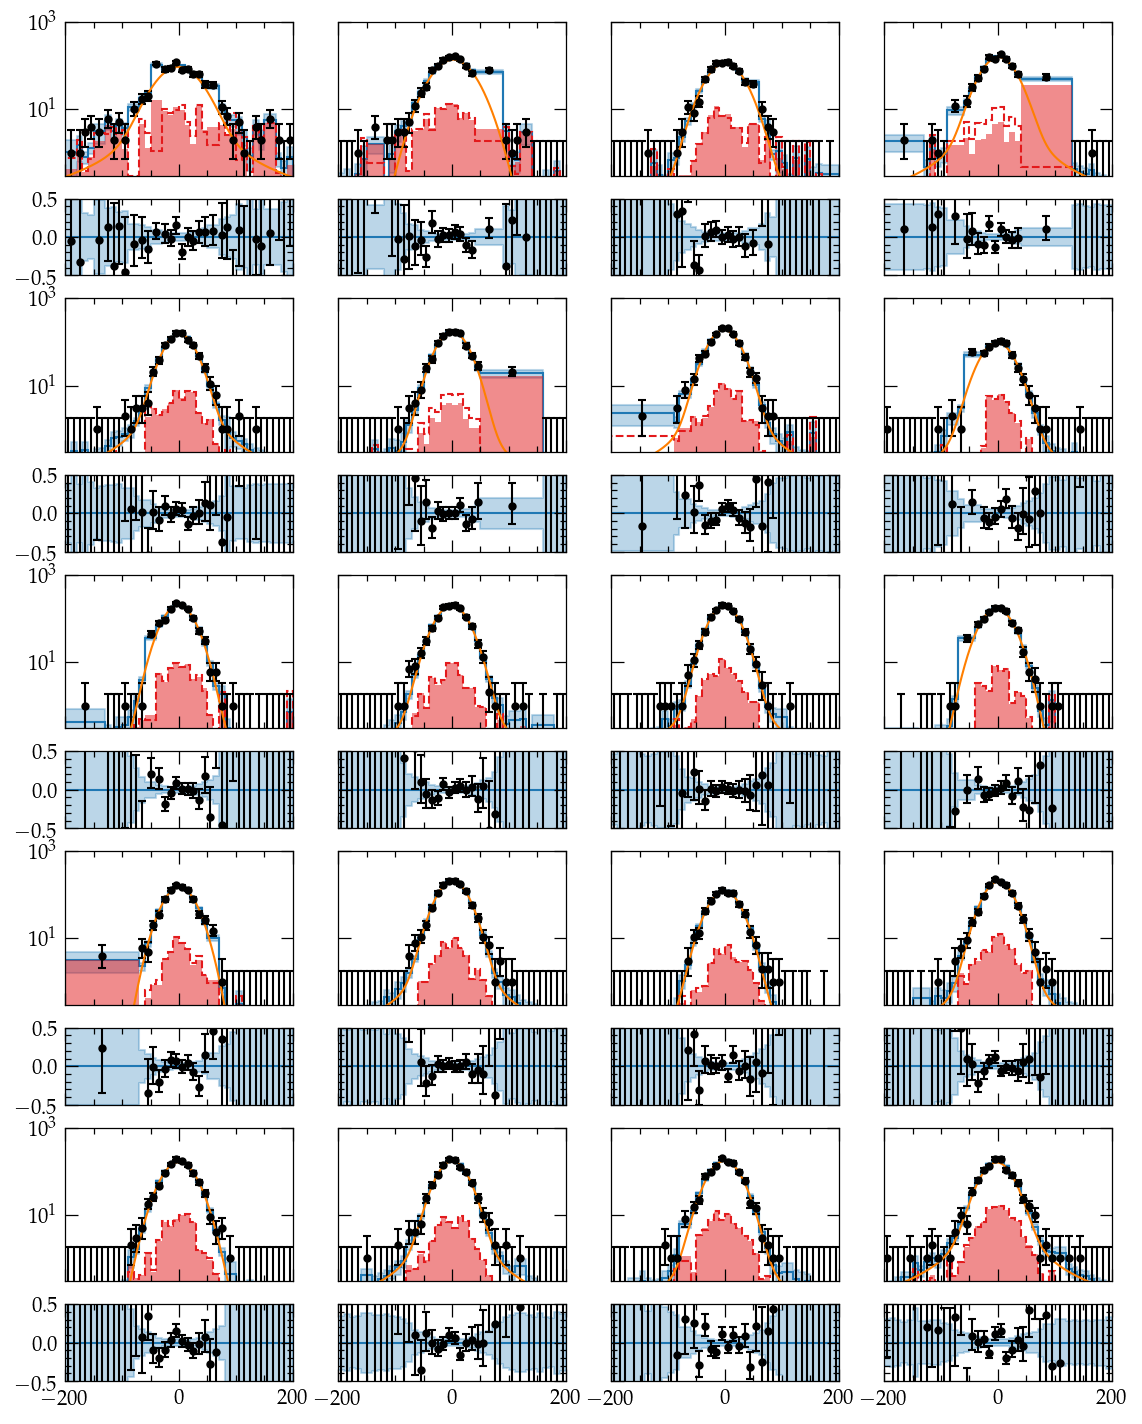

In [24]:
model = LogLHData(nll, sig_pdf, bkg_pdf, gen_data)
df_data_region = df_data.loc[("central", "ZCand_pt", "METnoX_ptPerpZCandCent", "DoubleElectron", "SingleElectron"),:].groupby(["binvar0", "binvar1"]).sum()
df_mc_region = df_mc.loc[("central", "ZCand_pt", "METnoX_ptPerpZCandCent", "DoubleElectron"),:].groupby(["parent", "binvar0", "binvar1"]).sum()

binning = np.arange(-210.,  201., 10.)

fix, ax = plt.subplots(
    figsize=(9,12), dpi=150,
    nrows=10, ncols=4,
    sharex=True, sharey='row',
    gridspec_kw=dict(
        height_ratios=(2,1, 2,1, 2,1, 2,1, 2,1),
        hspace=0.2, wspace=0.2,
    ),
)

minimizers_data = []
for idx in tqdm(range(zpt_bin_edges_round.shape[0]-1)):
    mod, mini = perform_data_fit(model, binning, df_data_region, df_mc_region, idx=idx)
    
    loc_top = 2*(idx//4), idx%4
    loc_bot = 2*(idx//4)+1, idx%4
    draw_data_fit_results((ax[loc_top], ax[loc_bot]), mod, mini)
    ax[loc_top].set_xlim(-200., 200.)
    ax[loc_top].set_ylim(0.3, 1e3)
    ax[loc_bot].set_ylim(-0.5, 0.5)
    minimizers_data.append(mini)

### Results

Overall the data fits perform well merging bins to avoid negative background weights.

## MC Fits

In [25]:
minimizers_mc = {}

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1976: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hep/sdb15/miniconda2/envs/

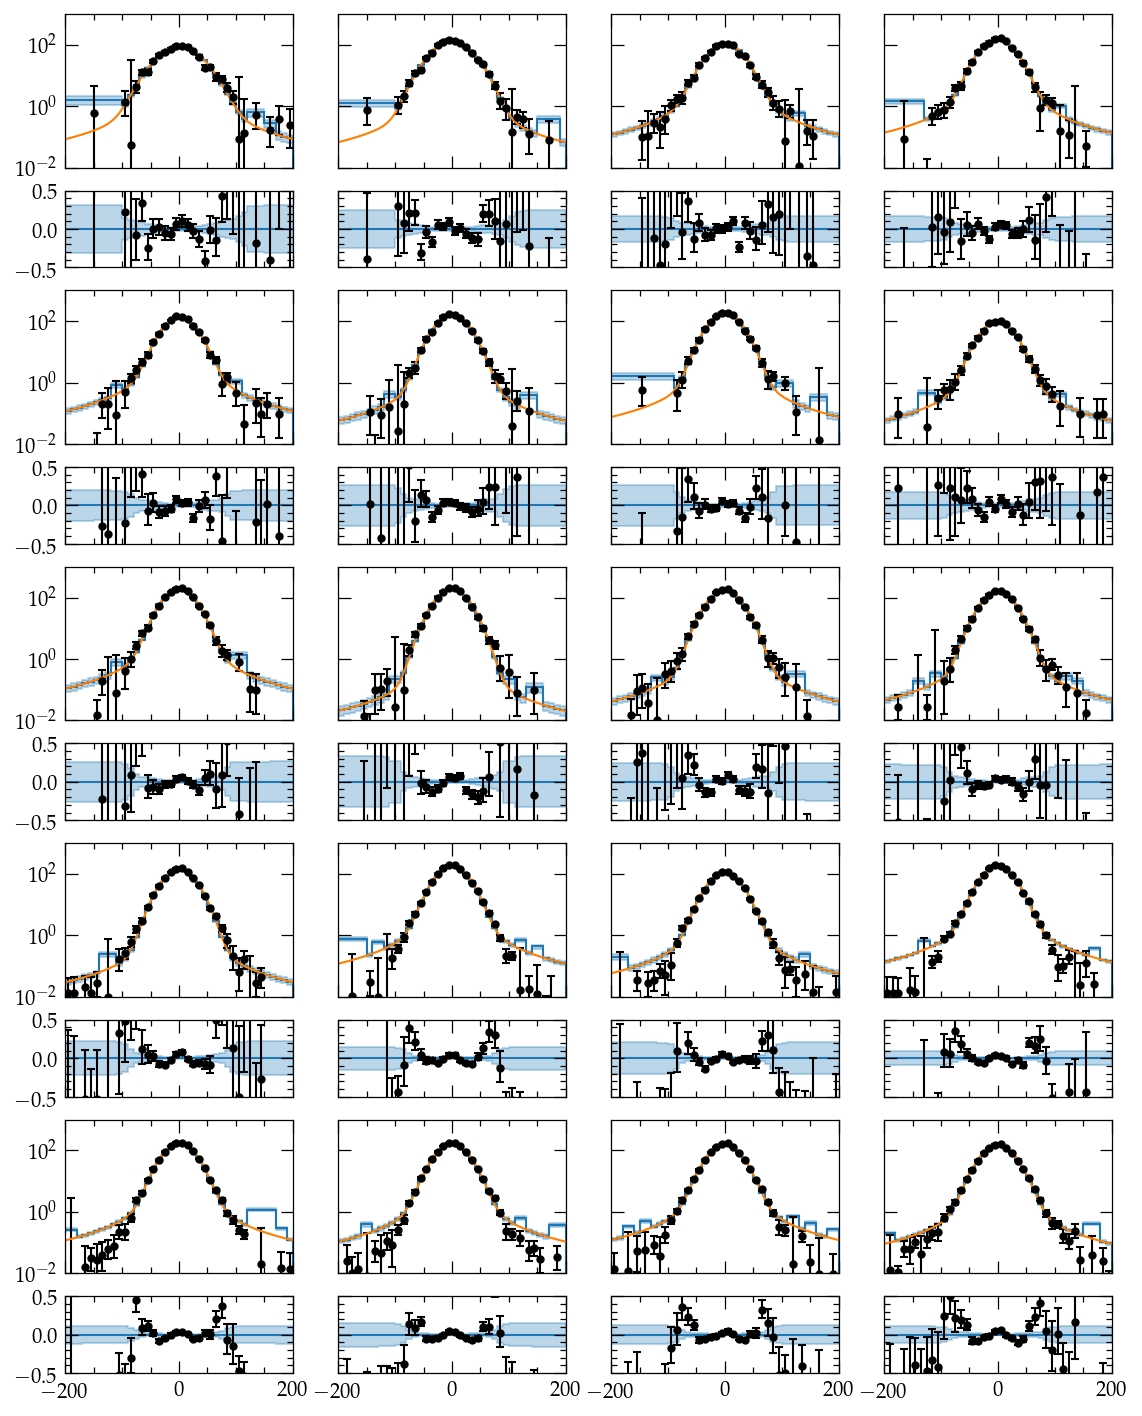

In [26]:
model = LogLHMC(nll_sigonly, sig_pdf, gen_data)
df_mc_region = df_mc.loc[("central", "ZCand_pt", "METnoX_ptPerpZCandCent", "DoubleElectron"),:].groupby(["parent", "binvar0", "binvar1"]).sum()

variation = ""
binning = np.arange(-210.,  201., 10.)

fix, ax = plt.subplots(
    figsize=(9,12), dpi=150,
    nrows=10, ncols=4,
    sharex=True, sharey='row',
    gridspec_kw=dict(
        height_ratios=(2,1, 2,1, 2,1, 2,1, 2,1),
        hspace=0.2, wspace=0.2,
    ),
)

minimizers_mc[variation] = []
for idx in tqdm(range(zpt_bin_edges_round.shape[0]-1)):
    mod, mini = perform_mc_fit(model, binning, df_mc_region, idx=idx, variation=variation)
    
    loc_top = 2*(idx//4), idx%4
    loc_bot = 2*(idx//4)+1, idx%4
    draw_mc_fit_results((ax[loc_top], ax[loc_bot]), mod, mini)
    ax[loc_top].set_xlim(-200., 200.)
    ax[loc_top].set_ylim(1e-2, 1e3)
    ax[loc_bot].set_ylim(-0.5, 0.5)
    minimizers_mc[variation].append(mini)

### Results

Ok results with the MC fits. However, the signal PDF doesn't capture the tails of the distribution so well. However, this does not capture the systematic variations, only the MC statistical uncertainty which should be subdominant for the signal which has plenty of events. Next we'll look at the systematic variations.

## Draw all fit results

Combine all the fit results vs. $\mathrm{Z}\ p_{\mathrm{T}}$

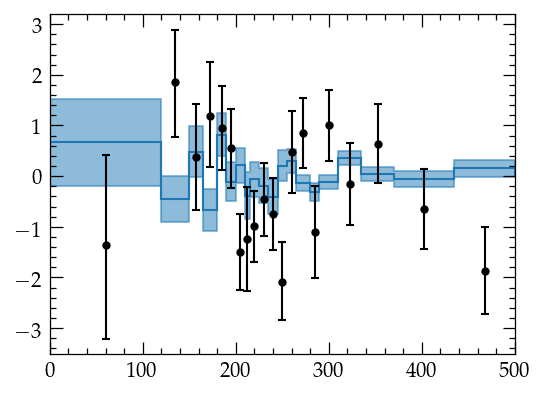

In [27]:
df_results_data = pd.DataFrame([{
    "binvar0_min": zpt_bin_edges_round[idx],
    "binvar0_max": zpt_bin_edges_round[idx+1],
    "x0": m.values["x0"],
    "x0_up": m.merrors[("x0", 1.0)],
    "x0_down": m.merrors[("x0", -1.0)],
    "sigmav": m.values["sigmav"],
    "sigmav_up": m.merrors[("sigmav", 1.0)],
    "sigmav_down": m.merrors[("sigmav", -1.0)],
} for idx, m in enumerate(minimizers_data)])

df_results_mc = pd.DataFrame([{
    "binvar0_min": zpt_bin_edges_round[idx],
    "binvar0_max": zpt_bin_edges_round[idx+1],
    "x0": m.values["x0"],
    "x0_up": m.merrors[("x0", 1.0)],
    "x0_down": m.merrors[("x0", -1.0)],
    "sigmav": m.values["sigmav"],
    "sigmav_up": m.merrors[("sigmav", 1.0)],
    "sigmav_down": m.merrors[("sigmav", -1.0)],
} for idx, m in enumerate(minimizers_mc[""])])

fig, ax = plt.subplots(
    figsize=(4, 3), dpi=150,
)

bin_low = df_results_data["binvar0_min"].values
bin_edge = np.array(list(bin_low) + [2*bin_low[-1]-bin_low[-2]])
bin_cent = (bin_edge[1:] + bin_edge[:-1])/2.
ax.errorbar(
    bin_cent,
    df_results_data["x0"],
    yerr=np.abs(df_results_data[["x0_down", "x0_up"]].values.T),
    fmt='o', color='black',
)
ax.set_xlim(bin_edge[0], bin_edge[-1])

ax.hist(
    bin_cent,
    bins=bin_edge,
    weights=df_results_mc["x0"],
    histtype='step',
    color='#1f78b4'
)

ax.fill_between(
    bin_edge,
    list(df_results_mc.eval("x0+x0_down").values) + [0.],
    list(df_results_mc.eval("x0+x0_up").values) + [0.],
    color='#1f78b4',
    alpha=0.5,
    step='post',
)

#ax.set_xscale('log')
#ax.set_xlim(5e1, bin_edge.max())
pass

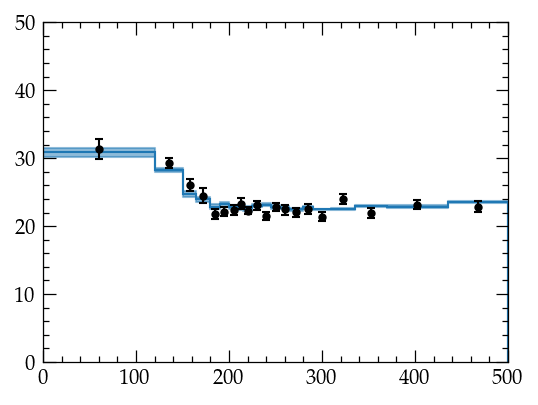

In [28]:
df_results_data = pd.DataFrame([{
    "binvar0_min": zpt_bin_edges_round[idx],
    "binvar0_max": zpt_bin_edges_round[idx+1],
    "x0": m.values["x0"],
    "x0_up": m.merrors[("x0", 1.0)],
    "x0_down": m.merrors[("x0", -1.0)],
    "sigmav": m.values["sigmav"],
    "sigmav_up": m.merrors[("sigmav", 1.0)],
    "sigmav_down": m.merrors[("sigmav", -1.0)],
} for idx, m in enumerate(minimizers_data)])

df_results_mc = pd.DataFrame([{
    "binvar0_min": zpt_bin_edges_round[idx],
    "binvar0_max": zpt_bin_edges_round[idx+1],
    "x0": m.values["x0"],
    "x0_up": m.merrors[("x0", 1.0)],
    "x0_down": m.merrors[("x0", -1.0)],
    "sigmav": m.values["sigmav"],
    "sigmav_up": m.merrors[("sigmav", 1.0)],
    "sigmav_down": m.merrors[("sigmav", -1.0)],
} for idx, m in enumerate(minimizers_mc[""])])

fig, ax = plt.subplots(
    figsize=(4, 3), dpi=150,
)

bin_low = df_results_data["binvar0_min"].values
bin_edge = np.array(list(bin_low) + [2*bin_low[-1]-bin_low[-2]])
bin_cent = (bin_edge[1:] + bin_edge[:-1])/2.
ax.errorbar(
    bin_cent,
    df_results_data["sigmav"],
    yerr=np.abs(df_results_data[["sigmav_down", "sigmav_up"]].values.T),
    fmt='o', color='black',
)
ax.set_xlim(bin_edge[0], bin_edge[-1])

ax.hist(
    bin_cent,
    bins=bin_edge,
    weights=df_results_mc["sigmav"],
    histtype='step',
    color='#1f78b4'
)

ax.fill_between(
    bin_edge,
    list(df_results_mc.eval("sigmav+sigmav_down").values) + [0.],
    list(df_results_mc.eval("sigmav+sigmav_up").values) + [0.],
    color='#1f78b4',
    alpha=0.5,
    step='post',
)

#ax.set_xscale('log')
#ax.set_xlim(5e1, bin_edge.max())
ax.set_ylim(0., 50.)
pass

## Systematic variations

In [29]:
[c for c in df_mc.columns if c.startswith("sum_w_") and (c.endswith("Up") or "lhe" in c)]

['sum_w_d1kqcdUp',
 'sum_w_d2kqcdUp',
 'sum_w_d3kqcdUp',
 'sum_w_d1kewUp',
 'sum_w_d2kewzUp',
 'sum_w_d2kewwUp',
 'sum_w_d3kewzUp',
 'sum_w_d3kewwUp',
 'sum_w_dkmixUp',
 'sum_w_pileupUp',
 'sum_w_prefiringUp',
 'sum_w_muonTrigUp',
 'sum_w_muonIdLooseStatUp',
 'sum_w_muonIdLooseSystUp',
 'sum_w_muonIsoLooseStatUp',
 'sum_w_muonIsoLooseSystUp',
 'sum_w_muonIdTightStatUp',
 'sum_w_muonIdTightSystUp',
 'sum_w_muonIsoTightStatUp',
 'sum_w_muonIsoTightSystUp',
 'sum_w_eleTrigUp',
 'sum_w_eleIdIsoVetoUp',
 'sum_w_eleIdIsoTightUp',
 'sum_w_eleRecoUp',
 'sum_w_photonIdLooseUp',
 'sum_w_photonPixelSeedVetoUp',
 'sum_w_tauIdVLooseUp',
 'sum_w_tauIdTightUp',
 'sum_w_btagSFUp',
 'sum_w_metTrigMuonMultiplicitySystUp',
 'sum_w_metTrigReferenceTriggerSystUp',
 'sum_w_metTrigRegionSystUp',
 'sum_w_lheScaleWeight0',
 'sum_w_lheScaleWeight1',
 'sum_w_lheScaleWeight2',
 'sum_w_lheScaleWeight3',
 'sum_w_lheScaleWeight4',
 'sum_w_lheScaleWeight5',
 'sum_w_lheScaleWeight6',
 'sum_w_lheScaleWeight7',
 'sum_w_

In [30]:
systs_weights = [
    "d1kqcdUp", "d1kqcdDown",
    "d2kqcdUp", "d2kqcdDown",
    "d3kqcdUp", "d3kqcdDown",
    "d1kewUp", "d1kewDown",
    "d2kewzUp", "d2kewzDown",
    "d2kewwUp", "d2kewwDown",
    "d3kewzUp", "d3kewzDown",
    "d3kewwUp", "d3kewwDown",
    "dkmixUp", "dkmixDown",
    "pileupUp", "pileupDown",
    "prefiringUp", "prefiringDown",
    'muonTrigUp', 'muonTrigDown',
    'muonIdLooseStatUp', 'muonIdLooseStatDown',
    'muonIdLooseSystUp', 'muonIdLooseSystDown',
    'muonIsoLooseStatUp', 'muonIsoLooseStatDown',
    'muonIsoLooseSystUp', 'muonIsoLooseSystDown',
    'muonIdTightStatUp', 'muonIdTightStatDown',
    'muonIdTightSystUp', 'muonIdTightSystDown',
    'muonIsoTightStatUp', 'muonIsoTightStatDown',
    'muonIsoTightSystUp', 'muonIsoTightSystDown',
    'eleTrigUp', 'eleTrigDown',
    'eleIdIsoVetoUp', 'eleIdIsoVetoDown',
    'eleIdIsoTightUp', 'eleIdIsoTightDown',
    'eleRecoUp', 'eleRecoDown',
    'photonIdLooseUp', 'photonIdLooseDown',
    'photonPixelSeedVetoUp', 'photonPixelSeedVetoDown',
    'tauIdTightUp', 'tauIdTightDown',
    'tauIdVLooseUp', 'tauIdVLooseDown',
    'btagSFUp', 'btagSFDown',
    'metTrigMuonMultiplicitySystUp', 'metTrigMuonMultiplicitySystDown',
    'metTrigReferenceTriggerSystUp', 'metTrigReferenceTriggerSystDown',
    'metTrigRegionSystUp', 'metTrigRegionSystDown',
]

In [31]:
model = LogLHMC(nll_sigonly, sig_pdf, gen_data)
df_mc_region = df_mc.loc[("central", "ZCand_pt", "METnoX_ptPerpZCandCent", "DoubleElectron"),:].groupby(["parent", "binvar0", "binvar1"]).sum()

binning = np.arange(-210.,  201., 10.)

for variation in tqdm(systs_weights):
    minimizers_mc[variation] = []
    for idx in range(zpt_bin_edges_round.shape[0]-1):
        mod, mini = perform_mc_fit(model, binning, df_mc_region, idx=idx, variation=variation)
        
        #loc_top = 2*(idx//4), idx%4
        #loc_bot = 2*(idx//4)+1, idx%4
        #draw_mc_fit_results((ax[loc_top], ax[loc_bot]), mod, mini)
        #ax[loc_top].set_xlim(-200., 200.)
        #ax[loc_top].set_ylim(1e-2, 1e3)
        #ax[loc_bot].set_ylim(-0.5, 0.5)
        minimizers_mc[variation].append(mini)

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [32]:
model = LogLHMC(nll_sigonly, sig_pdf, gen_data)
df_mc_region = df_mc_jes.loc[(pd.IndexSlice[:], "ZCand_pt", "METnoX_ptPerpZCandCent", "DoubleElectron"),:].groupby(["table", "parent", "binvar0", "binvar1"]).sum()

binning = np.arange(-210.,  201., 10.)
for variation in ["jesTotalUp", "jesTotalDown"]:
    minimizers_mc[variation] = []
    
    for idx in tqdm(range(zpt_bin_edges_round.shape[0]-1)):
        mod, mini = perform_mc_fit_multipscale(
            model, binning, df_mc_region,
            idx=idx, variation=variation,
        )
        minimizers_mc[variation].append(mini)

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


In [33]:
df_mc_region = df_mc_jer.loc[(pd.IndexSlice[:], "ZCand_pt", "METnoX_ptPerpZCandCent", "DoubleElectron"),:].groupby(["table", "parent", "binvar0", "binvar1"]).sum()

binning = np.arange(-210.,  201., 10.)
for variation in ["jerSFUp", "jerSFDown"]:
    minimizers_mc[variation] = []
    
    for idx in tqdm(range(zpt_bin_edges_round.shape[0]-1)):
        mod, mini = perform_mc_fit_multipscale(
            model, binning, df_mc_region,
            idx=idx, variation=variation,
        )
        minimizers_mc[variation].append(mini)

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


In [34]:
df_mc_region = df_mc_unclust.loc[(pd.IndexSlice[:], "ZCand_pt", "METnoX_ptPerpZCandCent", "DoubleElectron"),:].groupby(["table", "parent", "binvar0", "binvar1"]).sum()

binning = np.arange(-210.,  201., 10.)
variation = "unclustUp"
for variation in ["unclustUp", "unclustDown"]:
    minimizers_mc[variation] = []
    
    for idx in tqdm(range(zpt_bin_edges_round.shape[0]-1)):
        mod, mini = perform_mc_fit_multipscale(
            model, binning, df_mc_region,
            idx=idx, variation=variation,
        )
        minimizers_mc[variation].append(mini)

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


### Lepton scale uncertainties

In [35]:
df_mc_region = df_mc_lepscale.loc[(pd.IndexSlice[:], "ZCand_pt", "METnoX_ptPerpZCandCent", "DoubleElectron"),:].groupby(["table", "parent", "binvar0", "binvar1"]).sum()

df_mc_w = pd.pivot_table(df_mc_region, values=["sum_w"], index=["parent", "binvar0", "binvar1"], columns=["table"]).fillna(0.)
df_mc_ww = pd.pivot_table(df_mc_region, values=["sum_ww"], index=["parent", "binvar0", "binvar1"], columns=["table"]).fillna(0.)

df_mc_w.columns = ["sum_w_"+c[1] for c in df_mc_w.columns]
df_mc_ww.columns = ["sum_ww_"+c[1] for c in df_mc_ww.columns]

df_mc_region = pd.concat([df_mc_w, df_mc_ww], axis=1)

In [36]:
model = LogLHMC(nll_sigonly, sig_pdf, gen_data)

In [37]:
binning = np.arange(-210.,  201., 10.)

for variation in [
    "muonPtScaleUp", "muonPtScaleDown",
    "eleEnergyScaleUp", "eleEnergyScaleDown",
    "photonEnergyScaleUp", "photonEnergyScaleDown",
    "tauPtScaleUp", "tauPtScaleDown",
]:
    minimizers_mc[variation] = []
    for idx in tqdm(range(zpt_bin_edges_round.shape[0]-1)):
        mod, mini = perform_mc_fit(
            model, binning, df_mc_region,
            idx=idx, variation=variation,
        )
        minimizers_mc[variation].append(mini)

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


### PDF variations

In [38]:
model = LogLHMC(nll_sigonly, sig_pdf, gen_data)
df_mc_region = df_mc.loc[("central", "ZCand_pt", "METnoX_ptPerpZCandCent", "DoubleElectron"),:].groupby(["parent", "binvar0", "binvar1"]).sum()

binning = np.arange(-210.,  201., 10.)

for variation in ["lhePdfWeightUp", "lhePdfWeightDown"]:
    minimizers_mc[variation] = []
    for idx in tqdm(range(zpt_bin_edges_round.shape[0]-1)):
        mod, mini = perform_mc_fit_pdfvariations(model, binning, df_mc_region, idx=idx, variation=variation)
        minimizers_mc[variation].append(mini)

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


### Scale variations

In [39]:
model = LogLHMC(nll_sigonly, sig_pdf, gen_data)
df_mc_region = df_mc.loc[("central", "ZCand_pt", "METnoX_ptPerpZCandCent", "DoubleElectron"),:].groupby(["parent", "binvar0", "binvar1"]).sum()

binning = np.arange(-210.,  201., 10.)

for variation in ["lheScaleWeightUp", "lheScaleWeightDown"]:
    minimizers_mc[variation] = []
    for idx in tqdm(range(zpt_bin_edges_round.shape[0]-1)):
        mod, mini = perform_mc_fit_scalevariations(model, binning, df_mc_region, idx=idx, variation=variation)
        minimizers_mc[variation].append(mini)

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


### Combine systematics

In [40]:
data_results = []
for key, vals in minimizers_mc.items():
    if any(x in key for x in ["eleEnergyScale", "photonEnergyScale", "tauPtScale"]):
        continue
    for idx, m in enumerate(vals):
        if m is None:
            continue
        upordown = "up" if key.lower().endswith("up") else "down"
        data_results.append({
            "variation": key[:-4] if key.lower().endswith("down") else key[:-2] if key.lower().endswith("up") else key,
            "updown": upordown,
            "binvar0_min": zpt_bin_edges_round[idx],
            "binvar0_max": zpt_bin_edges_round[idx+1],
            "x0": m.values["x0"],
            "x0_up": m.merrors[("x0", 1.0)],
            "x0_down": m.merrors[("x0", -1.0)],
            "sigmav": m.values["sigmav"],
            "sigmav_up": m.merrors[("sigmav", 1.0)],
            "sigmav_down": m.merrors[("sigmav", -1.0)],
        })
df_results = pd.DataFrame(data_results).set_index(["variation", "updown", "binvar0_min", "binvar0_max"])
df_results.to_hdf(
    "fit_results_ele.h5", "METnoX_ptPerpZCandCent_MCFitResults",
    format='table', append=True,
    complevel=9, complib='zlib',
)
df_cent = df_results.loc[("",),:].groupby(["binvar0_min", "binvar0_max"]).sum()

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/pandas/core/indexing.py:1404: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [41]:
df_cent[["x0", "sigmav"]]
#df_x0_syst_diff = pd.pivot_table(df_results, values=["x0"], index=["binvar0_min", "binvar0_max"], columns=["variation"]).subtract(df_cent["x0"], axis=0).stack()
df_x0_syst_diff = pd.pivot_table(
    df_results.loc[~(df_results.index.get_level_values("variation")==""),:], values=["x0"], index=["binvar0_min", "binvar0_max"], columns=["updown", "variation"],
).subtract(df_cent["x0"], axis=0).stack()

df_cent_x0 = df_cent[["x0_down", "x0_up"]]
df_cent_x0.columns = ["down", "up"]
df_cent_x0 = df_cent_x0.reset_index()
df_cent_x0["variation"] = "stat"
df_cent_x0 = df_cent_x0.set_index(["binvar0_min", "binvar0_max", "variation"])
df_x0_syst_diff.columns = [c[1] for c in df_x0_syst_diff.columns]
df_x0_unc_diff = pd.concat([df_cent_x0, df_x0_syst_diff], axis=0).sort_values(["binvar0_min", "binvar0_max", "variation"])
df_x0_unc_diff_total = np.sqrt((pd.DataFrame({
    "down": np.minimum(0., df_x0_unc_diff.min(axis=1)),
    "up": np.maximum(0., df_x0_unc_diff.max(axis=1)),
}, index=df_x0_unc_diff.index)**2).groupby(["binvar0_min", "binvar0_max"]).sum())

In [42]:
data_results = []
for idx, m in enumerate(minimizers_data):
    data_results.append({
        "binvar0_min": zpt_bin_edges_round[idx],
        "binvar0_max": zpt_bin_edges_round[idx+1],
        "x0": m.values["x0"],
        "x0_up": m.merrors[("x0", 1.0)],
        "x0_down": m.merrors[("x0", -1.0)],
        "sigmav": m.values["sigmav"],
        "sigmav_up": m.merrors[("sigmav", 1.0)],
        "sigmav_down": m.merrors[("sigmav", -1.0)],
    })
df_data_results = pd.DataFrame(data_results).set_index(["binvar0_min", "binvar0_max"])
df_data_results.to_hdf(
    "fit_results_ele.h5", "METnoX_ptPerpZCandCent_DataFitResults",
    format="table", append=True,
    complevel=9, complib='zlib',
)
df_data_results

,,x0,x0_up,x0_down,sigmav,sigmav_up,sigmav_down
binvar0_min,binvar0_max,,,,,,
0.0,120.0,-1.360638,1.773907,-1.847221,31.390070,1.479963,-1.549617
120.0,150.0,1.851428,1.040391,-1.073733,29.288933,0.784456,-0.791471
150.0,165.0,0.381799,1.043300,-1.054534,25.996057,0.869270,-0.893876
165.0,180.0,1.181036,1.065644,-1.010612,24.478689,1.105666,-1.033480
180.0,190.0,0.947659,0.833239,-0.831930,21.795942,0.740530,-0.730001
190.0,200.0,0.550006,0.785265,-0.784272,22.120649,0.717898,-0.706630
200.0,210.0,-1.498131,0.744165,-0.742829,22.384905,0.697275,-0.682814
210.0,215.0,-1.248574,1.029583,-1.012741,23.308397,0.830427,-0.813078
215.0,225.0,-0.987713,0.700636,-0.701651,22.234640,0.529501,-0.517444


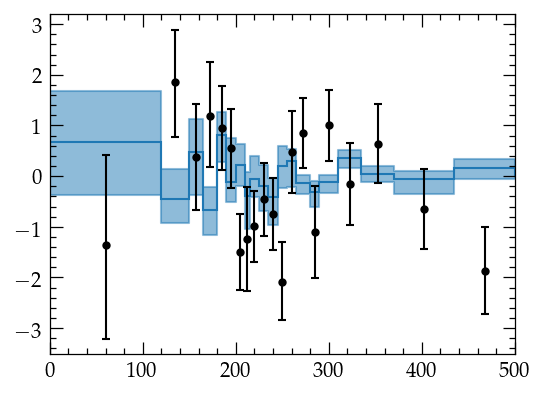

In [43]:
fig, ax = plt.subplots(
    figsize=(4, 3), dpi=150,
)

bin_low = df_results_data["binvar0_min"].values
bin_edge = np.array(list(bin_low) + [2*bin_low[-1]-bin_low[-2]])
bin_cent = (bin_edge[1:] + bin_edge[:-1])/2.
ax.errorbar(
    bin_cent,
    df_results_data["x0"],
    yerr=np.abs(df_results_data[["x0_down", "x0_up"]].values.T),
    fmt='o', color='black',
)
ax.set_xlim(bin_edge[0], bin_edge[-1])

ax.hist(
    bin_cent,
    bins=bin_edge,
    weights=df_results_mc["x0"],
    histtype='step',
    color='#1f78b4'
)

ax.fill_between(
    bin_edge,
    list(df_results_mc["x0"].values-df_x0_unc_diff_total["down"].values) + [0.],
    list(df_results_mc["x0"].values+df_x0_unc_diff_total["up"].values) + [0.],
    color='#1f78b4',
    alpha=0.5,
    step='post',
)

#ax.set_xscale('log')
#ax.set_xlim(5e1, bin_edge.max())
#ax.set_ylim(0., 10.)
pass

In [44]:
df_cent[["x0", "sigmav"]]
#df_sigmav_syst_diff = pd.pivot_table(df_results, values=["sigmav"], index=["binvar0_min", "binvar0_max"], columns=["variation"]).subtract(df_cent["sigmav"], axis=0).stack()
df_sigmav_syst_diff = pd.pivot_table(
    df_results.loc[~(df_results.index.get_level_values("variation")==""),:], values=["sigmav"], index=["binvar0_min", "binvar0_max"], columns=["updown", "variation"],
).subtract(df_cent["sigmav"], axis=0).stack()

df_cent_sigmav = df_cent[["sigmav_down", "sigmav_up"]]
df_cent_sigmav.columns = ["down", "up"]
df_cent_sigmav = df_cent_sigmav.reset_index()
df_cent_sigmav["variation"] = "stat"
df_cent_sigmav = df_cent_sigmav.set_index(["binvar0_min", "binvar0_max", "variation"])
df_sigmav_syst_diff.columns = [c[1] for c in df_sigmav_syst_diff.columns]
df_sigmav_unc_diff = pd.concat([df_cent_sigmav, df_sigmav_syst_diff], axis=0).sort_values(["binvar0_min", "binvar0_max", "variation"])
df_sigmav_unc_diff_total = np.sqrt((pd.DataFrame({
    "down": np.minimum(0., df_sigmav_unc_diff.min(axis=1)),
    "up": np.maximum(0., df_sigmav_unc_diff.max(axis=1)),
}, index=df_sigmav_unc_diff.index)**2).groupby(["binvar0_min", "binvar0_max"]).sum())

In [45]:
df_sigmav_unc_diff.columns = ["sigmav_down", "sigmav_up"]
df_x0_unc_diff.columns = ["x0_down", "x0_up"]

pd.concat([df_x0_unc_diff, df_sigmav_unc_diff], axis=1).to_hdf(
    "fit_results_ele.h5", "METnoX_ptPerpZCandCent_MCFitSysts",
    format="table", append=True,
    complevel=9, complib='zlib',
)

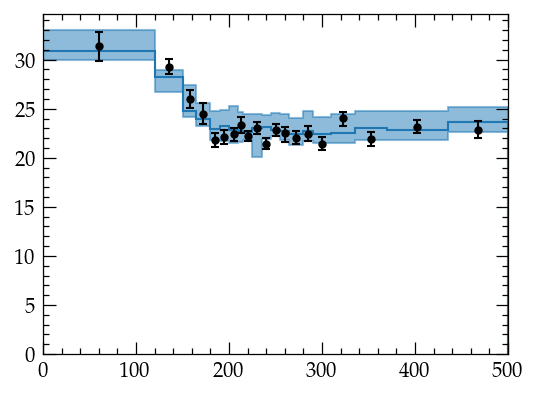

In [46]:
fig, ax = plt.subplots(
    figsize=(4, 3), dpi=150,
)

bin_low = df_results_data["binvar0_min"].values
bin_edge = np.array(list(bin_low) + [2*bin_low[-1]-bin_low[-2]])
bin_cent = (bin_edge[1:] + bin_edge[:-1])/2.
ax.errorbar(
    bin_cent,
    df_results_data["sigmav"],
    yerr=np.abs(df_results_data[["sigmav_down", "sigmav_up"]].values.T),
    fmt='o', color='black',
)
ax.set_xlim(bin_edge[0], bin_edge[-1])

ax.hist(
    bin_cent,
    bins=bin_edge,
    weights=df_results_mc["sigmav"],
    histtype='step',
    color='#1f78b4'
)

ax.fill_between(
    bin_edge,
    list(df_results_mc["sigmav"].values-df_sigmav_unc_diff_total["down"].values) + [0.],
    list(df_results_mc["sigmav"].values+df_sigmav_unc_diff_total["up"].values) + [0.],
    color='#1f78b4',
    alpha=0.5,
    step='post',
)

#ax.set_xscale('log')
#ax.set_xlim(5e1, bin_edge.max())
#ax.set_ylim(0., 40.)
pass